# Recycling in Europe - Data Preprocessing Pipeline

This notebook processes and cleans multiple datasets related to recycling rates and environmental factors across European countries. The datasets are combined to create a unified dataset for analysis.

## Overview of Datasets:
- **D1**: General recycling rates (overall waste recycling %)
- **D2**: Recycling rates by waste type (glass, plastic, paper, metallic, wooden, packaging)
- **D3**: Socioeconomic indicators (GDP per capita, urbanization, internet usage, renewable energy, etc.)
- **CEI**: Circular economy indicators (private investments and output of circular economy sectors)
- **ENV**: Environmental tax revenues (as % of GDP)


# Imports

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [266]:
MISSING_RATE = 0.9
EU_COUNTRIES = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 
    'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 
    'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 
    'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 
    'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 
    'Spain', 'Sweden'
]

# Preprocessing

## Functions

In [267]:
def fill_missing(series: pd.Series) -> pd.Series:
    # 1. interpolation for internal gaps
    # 2. backward fill for leading NaNs
    # 3. forward fill for trailing NaNs
    return series.interpolate().bfill().ffill()

## D1 - general recylcing rates

In [268]:
d1 = pd.read_csv("raw_data/d1.csv")

In [269]:
res_d1 = d1.copy()
res_d1 = res_d1[['geo', 'TIME_PERIOD', "OBS_VALUE", "OBS_FLAG"]]
res_d1 = res_d1.rename(columns={"geo": "country_name",
                                "TIME_PERIOD": "year",
                                "OBS_VALUE": "recycling_rate",
                                "OBS_FLAG": "flag"})
res_d1['country_name'] = res_d1['country_name'].astype("string")
res_d1['year'] = res_d1['year'].astype(int)
res_d1['recycling_rate'] = res_d1['recycling_rate'].astype(float)
res_d1['flag'] = res_d1['flag'].astype("string")

missing_rates_d1 = pd.DataFrame(res_d1.groupby("country_name")["recycling_rate"].apply(lambda x: x.isna().mean())).reset_index()
missing_rates_d1.to_csv("processed_data/missing_value_rates_d1.csv", index=False)

values_to_drop_d1 = []
for index, row in missing_rates_d1.iterrows():
    if row['recycling_rate'] > MISSING_RATE:
        values_to_drop_d1.append(row['country_name'])
res_d1 = res_d1[~res_d1['country_name'].isin(values_to_drop_d1)]
print(f"Dropped countries in d1 (n={len(values_to_drop_d1)}):", values_to_drop_d1)

res_d1['recycling_rate_filled'] = res_d1.groupby("country_name")["recycling_rate"].transform(fill_missing)

Dropped countries in d1 (n=1): ['Euro area – 20 countries (from 2023)']


In [270]:
res_d1.isna().sum()

country_name               0
year                       0
recycling_rate           134
flag                     755
recycling_rate_filled      0
dtype: int64

In [271]:
res_d1.to_csv("processed_data/preprocessed_d1.csv", index=False)

## D2 - different types of waste

In [272]:
d2 = pd.read_csv("raw_data/d2.csv")

In [273]:
res_d2 = d2.copy()
res_d2 = res_d2[['geo', 'TIME_PERIOD', 'waste', 'OBS_VALUE', 'OBS_FLAG']]
res_d2 = res_d2.rename(columns={"geo": "country_name",
                                "TIME_PERIOD": "year",
                                "waste": "waste_type",
                                "OBS_VALUE": "recycling_rate",
                                "OBS_FLAG": "flag"})
res_d2['country_name'] = res_d2['country_name'].astype("string")
res_d2['year'] = res_d2['year'].astype(int)
res_d2['waste_type'] = res_d2['waste_type'].astype("string")
res_d2['recycling_rate'] = res_d2['recycling_rate'].astype(float)
res_d2['flag'] = res_d2['flag'].astype("string")

missing_rates_d2 = pd.DataFrame(res_d2.groupby(["country_name", 'waste_type'])["recycling_rate"].apply(lambda x: x.isna().mean())).reset_index()
missing_rates_d2.to_csv("processed_data/missing_value_rates_d2.csv", index=False)

values_to_drop_d2 = set()
for index, row in missing_rates_d2.iterrows():
    country_name = row['country_name']
    waste_type = row['waste_type']
    rate = row['recycling_rate']
    if rate > MISSING_RATE:
        values_to_drop_d2.add(country_name)
        print(f"{country_name}\t{waste_type}")

res_d2 = res_d2[~res_d2['country_name'].isin(values_to_drop_d2)]
print(f"Dropped countries in d2 (n={len(values_to_drop_d2)}):", values_to_drop_d2)

res_d2['recycling_rate_filled'] = res_d2.groupby(["country_name", "waste_type"])["recycling_rate"].transform(fill_missing)

clean_names = {
    "Glass packaging": "glass",
    "Metallic packaging": "metallic",
    "Packaging": "packaging",
    "Paper and cardboard packaging": "paper",
    "Plastic packaging": "plastic",
    "Wooden packaging": "wooden"
}
res_d2['waste_type'] = res_d2['waste_type'].map(clean_names)

res_d2 = res_d2.pivot(index=['country_name', 'year'], columns='waste_type', values=['recycling_rate_filled', "recycling_rate", "flag"]).reset_index()
res_d2.columns = [f"{val}_{waste}" if waste else val for val, waste in res_d2.columns]

Albania	Glass packaging
Albania	Metallic packaging
Albania	Packaging
Albania	Paper and cardboard packaging
Albania	Plastic packaging
Albania	Wooden packaging
Euro area - 19 countries  (2015-2022)	Glass packaging
Euro area - 19 countries  (2015-2022)	Metallic packaging
Euro area - 19 countries  (2015-2022)	Packaging
Euro area - 19 countries  (2015-2022)	Paper and cardboard packaging
Euro area - 19 countries  (2015-2022)	Plastic packaging
Euro area - 19 countries  (2015-2022)	Wooden packaging
Euro area – 20 countries (from 2023)	Glass packaging
Euro area – 20 countries (from 2023)	Metallic packaging
Euro area – 20 countries (from 2023)	Packaging
Euro area – 20 countries (from 2023)	Paper and cardboard packaging
Euro area – 20 countries (from 2023)	Plastic packaging
Euro area – 20 countries (from 2023)	Wooden packaging
Montenegro	Glass packaging
Montenegro	Metallic packaging
Montenegro	Packaging
Montenegro	Paper and cardboard packaging
Montenegro	Plastic packaging
Montenegro	Wooden packag

In [274]:
res_d2.isna().sum()

country_name                         0
year                                 0
recycling_rate_filled_glass          0
recycling_rate_filled_metallic       0
recycling_rate_filled_packaging      0
recycling_rate_filled_paper          0
recycling_rate_filled_plastic        0
recycling_rate_filled_wooden         0
recycling_rate_glass                 7
recycling_rate_metallic              7
recycling_rate_packaging             7
recycling_rate_paper                 7
recycling_rate_plastic               7
recycling_rate_wooden                7
flag_glass                         330
flag_metallic                      336
flag_packaging                     339
flag_paper                         330
flag_plastic                       329
flag_wooden                        326
dtype: int64

In [275]:
res_d2.to_csv("processed_data/preprocessed_d2.csv", index=False)

In [276]:
res_d2['year'].min(), res_d2['year'].max()

(np.int64(2012), np.int64(2023))

## Checking country overlap between D1 and D2

In [277]:
for c in res_d1['country_name'].unique():
    if c not in res_d2['country_name'].unique():
        print(c)

Albania
Bosnia and Herzegovina
Switzerland
Montenegro
North Macedonia
Serbia
Türkiye
Kosovo*


In [278]:
for c in res_d2['country_name'].unique():
    if c not in res_d1['country_name'].unique():
        print(c)

Liechtenstein


In [279]:
values_to_drop_d1

['Euro area – 20 countries (from 2023)']

In [280]:
values_to_drop_d2

{'Albania',
 'Euro area - 19 countries  (2015-2022)',
 'Euro area – 20 countries (from 2023)',
 'Montenegro',
 'North Macedonia',
 'Serbia',
 'Switzerland',
 'Türkiye',
 'United Kingdom'}

In [281]:
countries = set(res_d1['country_name'].unique()).union(set(res_d2['country_name'].unique()))

In [282]:
countries

{'Albania',
 'Austria',
 'Belgium',
 'Bosnia and Herzegovina',
 'Bulgaria',
 'Croatia',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Estonia',
 'European Union - 27 countries (from 2020)',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hungary',
 'Iceland',
 'Ireland',
 'Italy',
 'Kosovo*',
 'Latvia',
 'Liechtenstein',
 'Lithuania',
 'Luxembourg',
 'Malta',
 'Montenegro',
 'Netherlands',
 'North Macedonia',
 'Norway',
 'Poland',
 'Portugal',
 'Romania',
 'Serbia',
 'Slovakia',
 'Slovenia',
 'Spain',
 'Sweden',
 'Switzerland',
 'Türkiye'}

## D3

In [283]:
d3 = pd.read_csv("raw_data/d3.csv")
d3

,Time,Time Code,Country Name,Country Code,GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD],Urban population (% of total population) [SP.URB.TOTL.IN.ZS],Individuals using the Internet (% of population) [IT.NET.USER.ZS],Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS],"International tourism, number of arrivals [ST.INT.ARVL]","Central government debt, total (current LCU) [GC.DOD.TOTL.CN]","Population, total [SP.POP.TOTL]","Manufacturing, value added (% of GDP) [NV.IND.MANF.ZS]",Government Effectiveness: Estimate [GE.EST],"Educational attainment, at least completed upper secondary, population 25+, total (%) (cumulative) [SE.SEC.CUAT.UP.ZS]",Households and NPISHs Final consumption expenditure per capita (constant 2015 US$) [NE.CON.PRVT.PC.KD]
0,2000,YR2000,Afghanistan,AFG,308.318269746638,18.558200,..,45,..,..,20130327.0,..,-2.17394614219666,..,..
1,2000,YR2000,Albania,ALB,1991.91435867116,41.613583,0.114097,41.4,317000,..,3089027.0,4.7114591532226,-0.917780160903931,..,1373.93215714894
2,2000,YR2000,Algeria,DZA,3553.32420521991,59.852124,0.491706,0.4,866000,..,30903893.0,44.9803977869361,-1.01074934005737,..,1133.42283142596
3,2000,YR2000,American Samoa,ASM,..,88.607581,..,0,44000,..,56855.0,..,..,..,..
4,2000,YR2000,Andorra,AND,34113.8334027285,92.255936,10.5388,14.5,10991000,..,65685.0,3.83085443139985,1.38048672676086,..,..
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5478,Data from database: World Development Indicators,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [284]:
for c in countries:
    if c not in d3['Country Name'].unique():
        print(c)

Türkiye
European Union - 27 countries (from 2020)
Slovakia
Kosovo*


In [285]:
d3 = d3.replace("Slovak Republic", "Slovakia")
d3 = d3.replace("Kosovo", "Kosovo*")
d3 = d3.replace("Turkiye", "Türkiye")
for c in countries:
    if c not in d3['Country Name'].unique():
        print(c)

European Union - 27 countries (from 2020)


In [286]:
d3 = d3[d3['Country Name'].isin(countries)]

In [287]:
d3

,Time,Time Code,Country Name,Country Code,GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD],Urban population (% of total population) [SP.URB.TOTL.IN.ZS],Individuals using the Internet (% of population) [IT.NET.USER.ZS],Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS],"International tourism, number of arrivals [ST.INT.ARVL]","Central government debt, total (current LCU) [GC.DOD.TOTL.CN]","Population, total [SP.POP.TOTL]","Manufacturing, value added (% of GDP) [NV.IND.MANF.ZS]",Government Effectiveness: Estimate [GE.EST],"Educational attainment, at least completed upper secondary, population 25+, total (%) (cumulative) [SE.SEC.CUAT.UP.ZS]",Households and NPISHs Final consumption expenditure per capita (constant 2015 US$) [NE.CON.PRVT.PC.KD]
1,2000,YR2000,Albania,ALB,1991.91435867116,41.613583,0.114097,41.4,317000,..,3089027.0,4.7114591532226,-0.917780160903931,..,1373.93215714894
11,2000,YR2000,Austria,AUT,38571.0858780001,66.769024,33.7301,26.4,17982000,..,8011566.0,18.726691043317,1.84726524353027,69.8805543658546,21252.0135794364
18,2000,YR2000,Belgium,BEL,35878.3153586195,82.015252,29.4317,1.4,6457000,..,10251250.0,17.5359744500664,1.65919423103333,50.0038123766939,19033.5860831606
24,2000,YR2000,Bosnia and Herzegovina,BIH,2567.34136989735,42.553990,1.08296,19.4,171000,..,4159771.0,9.29602274851537,-1.05737936496735,..,2244.37960786444
29,2000,YR2000,Bulgaria,BGR,3717.92889906166,68.263145,5.37092,8,4922000,..,8170172.0,..,0.0379754789173603,57.3747303537068,2080.74238459875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5430,2024,YR2024,Slovenia,SVN,26134.627203987,55.757771,90.7636,..,..,..,2127400.0,19.3670698018374,..,..,..
5435,2024,YR2024,Spain,ESP,29245.2192451729,80.315200,95.7575,..,..,..,48848840.0,10.8444299486305,..,55.6838432566667,..
5443,2024,YR2024,Sweden,SWE,54209.9474264877,88.855975,95.5293,..,..,..,10569709.0,13.0043168773902,..,..,..
5444,2024,YR2024,Switzerland,CHE,90067.4645431168,85.461537,..,..,..,..,9005582.0,17.6911811558258,..,84.3823784776807,..


In [288]:
res_d3 = d3.copy()
res_d3 = res_d3.iloc[:-5, :]
res_d3 = res_d3.rename(columns={"Time": "year",
                                "Country Name": "country_name",
                                "GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD]": "gdp_per_capita",
                                "Urban population (% of total population) [SP.URB.TOTL.IN.ZS]": "urban_population_pct",
                                "Individuals using the Internet (% of population) [IT.NET.USER.ZS]": "internet_users_pct",
                                "Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]": "renewable_energy_pct",
                                "International tourism, number of arrivals [ST.INT.ARVL]": "tourism_arrivals",
                                "Central government debt, total (% of GDP) [GC.DOD.TOTL.GD.ZS]": "government_debt_pct_gdp",
                                "Population, total [SP.POP.TOTL]": "population_total",
                                "Manufacturing, value added (% of GDP) [NV.IND.MANF.ZS]": "manufacturing_value_added_pct_gdp",
                                "Government Effectiveness: Estimate [GE.EST]": "government_effectiveness_estimate",
                                "Educational attainment, at least completed upper secondary, population 25+, total (%) (cumulative) [SE.SEC.CUAT.UP.ZS]": "highschool_completed_pct",
                                "Households and NPISHs Final consumption expenditure per capita (constant 2015 US$) [NE.CON.PRVT.PC.KD]": "household_exp_percapita"})

# remove central government debt, too many missing values
res_d3 = res_d3[["country_name", "year", "gdp_per_capita", "urban_population_pct",
                 "internet_users_pct", "renewable_energy_pct", "tourism_arrivals",
                 "population_total", "manufacturing_value_added_pct_gdp",
                 "government_effectiveness_estimate", "highschool_completed_pct", "household_exp_percapita"]]

res_d3 = res_d3.replace("..", np.nan)
res_d3['country_name'] = res_d3['country_name'].astype("string")
res_d3['year'] = res_d3['year'].astype(int)
res_d3['gdp_per_capita'] = res_d3['gdp_per_capita'].astype(float)
res_d3['urban_population_pct'] = res_d3['urban_population_pct'].astype(float)
res_d3['internet_users_pct'] = res_d3['internet_users_pct'].astype(float)
res_d3['renewable_energy_pct'] = res_d3['renewable_energy_pct'].astype(float)
res_d3['tourism_arrivals'] = res_d3['tourism_arrivals'].astype(float)
res_d3['population_total'] = res_d3['population_total'].astype(float)
res_d3['manufacturing_value_added_pct_gdp'] = res_d3['manufacturing_value_added_pct_gdp'].astype(float)
res_d3['government_effectiveness_estimate'] = res_d3['government_effectiveness_estimate'].astype(float)
res_d3['household_exp_percapita'] = res_d3['household_exp_percapita'].astype(float)
res_d3['highschool_completed_pct'] = res_d3['highschool_completed_pct'].astype(float)

values_to_drop_d3 = []
missing_rates_d3 = pd.DataFrame()
missing_rates_d3['country_name'] = res_d3['country_name'].unique()
for col in res_d3.columns:
    if col in ["country_name", "year"]:
        continue
    missing_rates_d3_col = pd.DataFrame(res_d3.groupby("country_name")[col].apply(lambda x: x.isna().mean())).reset_index()
    missing_rates_d3 = pd.merge(missing_rates_d3, missing_rates_d3_col, on='country_name', how='left', suffixes=('', f'_{col}'))
    for index, row in missing_rates_d3_col.iterrows():
        if row[col] > MISSING_RATE:
            values_to_drop_d3.append(row['country_name'])
            print(f"{row['country_name']}\t{col}")
missing_rates_d3.to_csv("processed_data/missing_value_rates_d3.csv", index=False)
res_d3 = res_d3[~res_d3['country_name'].isin(values_to_drop_d3)]


for col in res_d3.columns:
    if col in ["country_name", "year"]:
        continue
    res_d3[f"{col}_filled"] = res_d3.groupby("country_name")[col].transform(fill_missing)

Liechtenstein	gdp_per_capita
Kosovo*	internet_users_pct
Kosovo*	renewable_energy_pct
Kosovo*	tourism_arrivals
Bulgaria	manufacturing_value_added_pct_gdp
Kosovo*	highschool_completed_pct
Liechtenstein	highschool_completed_pct
Liechtenstein	household_exp_percapita


In [289]:
res_d3.isna().sum()

country_name                                  0
year                                          0
gdp_per_capita                                0
urban_population_pct                          0
internet_users_pct                           18
renewable_energy_pct                        105
tourism_arrivals                            183
population_total                              0
manufacturing_value_added_pct_gdp             0
government_effectiveness_estimate            69
highschool_completed_pct                    126
household_exp_percapita                      26
gdp_per_capita_filled                         0
urban_population_pct_filled                   0
internet_users_pct_filled                     0
renewable_energy_pct_filled                   0
tourism_arrivals_filled                       0
population_total_filled                       0
manufacturing_value_added_pct_gdp_filled      0
government_effectiveness_estimate_filled      0
highschool_completed_pct_filled         

In [290]:
res_d3.to_csv("processed_data/preprocessed_d3.csv", index=False)

## CEI - Private investment and gross value added (circular economy)

**Dataset**: Circular Economy Indicators (CEI)

**Description**: This dataset tracks the economic performance of circular economy sectors (recycling, repair, reuse) across European countries. It measures:
- **Private investments**: Gross investments in tangible goods.
- **Gross value added**: Economic output of circular economy sectors.

**Unit**: Millions of euros. Will join with population to get Mill/pop.

**Coverage**: All EU Member States, time series from 2005 onwards

**Preprocessing steps**:
1. Filter for investments as Millions of euros.
2. Drop countries with >90% missing values
3. Pivot wide format (indicators as columns)
4. Save cleaned dataset

In [291]:
cei = pd.read_csv("raw_data/cei_cie012.csv")
cei

,DATAFLOW,LAST UPDATE,freq,indic_env,unit,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS
0,ESTAT:CEI_CIE012(1.0),24/03/25 23:00:00,Annual,Gross value added,Million euro,Austria,2005,5295.0,NaN,NaN
1,ESTAT:CEI_CIE012(1.0),24/03/25 23:00:00,Annual,Gross value added,Million euro,Austria,2006,5321.0,NaN,NaN
2,ESTAT:CEI_CIE012(1.0),24/03/25 23:00:00,Annual,Gross value added,Million euro,Austria,2007,5466.0,NaN,NaN
3,ESTAT:CEI_CIE012(1.0),24/03/25 23:00:00,Annual,Gross value added,Million euro,Austria,2008,6653.0,NaN,NaN
4,ESTAT:CEI_CIE012(1.0),24/03/25 23:00:00,Annual,Gross value added,Million euro,Austria,2009,6130.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2191,ESTAT:CEI_CIE012(1.0),24/03/25 23:00:00,Annual,Investment,Percentage of gross domestic product (GDP),United Kingdom,2015,1.1,NaN,NaN
2192,ESTAT:CEI_CIE012(1.0),24/03/25 23:00:00,Annual,Investment,Percentage of gross domestic product (GDP),United Kingdom,2016,1.1,NaN,NaN
2193,ESTAT:CEI_CIE012(1.0),24/03/25 23:00:00,Annual,Investment,Percentage of gross domestic product (GDP),United Kingdom,2017,1.0,NaN,NaN
2194,ESTAT:CEI_CIE012(1.0),24/03/25 23:00:00,Annual,Investment,Percentage of gross domestic product (GDP),United Kingdom,2018,1.0,NaN,NaN


In [292]:
res_cei = cei.copy()
res_cei = res_cei.rename(columns={
    "geo": "country_name",
    "TIME_PERIOD": "year",
    "OBS_VALUE": "value",
    "indic_env": "indicator"
})
res_cei = res_cei[res_cei["unit"] == "Million euro"]
res_cei = res_cei[res_cei["country_name"].isin(EU_COUNTRIES)]

res_cei = res_cei[["country_name", "year", "indicator", "value"]]

res_cei["country_name"] = res_cei["country_name"].astype("string")
res_cei["year"] = res_cei["year"].astype(int)
res_cei["indicator"] = res_cei["indicator"].astype("string")
res_cei["value"] = res_cei["value"].astype(float)

res_cei.loc[res_cei["indicator"] == "Gross value added", "indicator"] = "gross_val_add_mill"
res_cei.loc[res_cei["indicator"] == "Investment", "indicator"] = "priv_invest_mill"

print("Unique indicators:", res_cei["indicator"].unique())
print("\nData shape:", res_cei.shape)
res_cei


Unique indicators: <StringArray>
['gross_val_add_mill', 'priv_invest_mill']
Length: 2, dtype: string

Data shape: (1026, 4)


,country_name,year,indicator,value
0,Austria,2005,gross_val_add_mill,5295.0
1,Austria,2006,gross_val_add_mill,5321.0
2,Austria,2007,gross_val_add_mill,5466.0
3,Austria,2008,gross_val_add_mill,6653.0
4,Austria,2009,gross_val_add_mill,6130.0
...,...,...,...,...
1625,Slovakia,2019,priv_invest_mill,506.0
1626,Slovakia,2020,priv_invest_mill,460.0
1627,Slovakia,2021,priv_invest_mill,530.0
1628,Slovakia,2022,priv_invest_mill,544.0


In [293]:
# Compute missing rates and drop countries
values_to_drop_cei = []
missing_rates_cei = pd.DataFrame()

for indicator in res_cei["indicator"].unique():
    subset = res_cei[res_cei["indicator"] == indicator]
    mr = pd.DataFrame(subset.groupby("country_name")["value"].apply(lambda x: x.isna().mean())).reset_index()
    mr.columns = ["country_name", "missing_rate"]
    mr["indicator"] = indicator
    
    for _, row in mr.iterrows():
        if row["missing_rate"] > MISSING_RATE:
            values_to_drop_cei.append(row["country_name"])
            print(f"{row['country_name']}\t{indicator}")
    
    missing_rates_cei = pd.concat([missing_rates_cei, mr], ignore_index=True)

missing_rates_cei.to_csv("processed_data/missing_value_rates_cei.csv", index=False)
values_to_drop_cei = list(set(values_to_drop_cei))
print(f"\nDropped countries in CEI (n={len(values_to_drop_cei)}):", values_to_drop_cei)

res_cei = res_cei[~res_cei["country_name"].isin(values_to_drop_cei)]

print(f"\nRemaining countries: {res_cei['country_name'].nunique()}")
print(f"Remaining rows: {len(res_cei)}")
res_cei


Dropped countries in CEI (n=0): []

Remaining countries: 27
Remaining rows: 1026


,country_name,year,indicator,value
0,Austria,2005,gross_val_add_mill,5295.0
1,Austria,2006,gross_val_add_mill,5321.0
2,Austria,2007,gross_val_add_mill,5466.0
3,Austria,2008,gross_val_add_mill,6653.0
4,Austria,2009,gross_val_add_mill,6130.0
...,...,...,...,...
1625,Slovakia,2019,priv_invest_mill,506.0
1626,Slovakia,2020,priv_invest_mill,460.0
1627,Slovakia,2021,priv_invest_mill,530.0
1628,Slovakia,2022,priv_invest_mill,544.0


In [294]:
# Fill missing per (country, indicator) time series
res_cei['value_filled'] = res_cei.groupby(['country_name', 'indicator'])['value'].transform(fill_missing)

# Pivot to wide format: each indicator becomes a column
res_cei_wide = res_cei.pivot_table(
    index=["country_name", "year"],
    columns="indicator",
    values=['value', 'value_filled'],
    aggfunc="first"
).reset_index()

# Flatten multi-level columns
res_cei_wide.columns = [f"{ind}_{val}" if ind else val 
                        for val, ind in res_cei_wide.columns]
res_cei_wide.columns = res_cei_wide.columns.str.replace('_value', '')

print("Final shape:", res_cei_wide.shape)
print("\nColumns:", list(res_cei_wide.columns))
print("\nMissing values:")
print(res_cei_wide.isna().sum())

res_cei_wide.to_csv("processed_data/preprocessed_cei.csv", index=False)
print("\nSaved to processed_data/preprocessed_cei.csv")

Final shape: (513, 6)

Columns: ['country_name', 'year', 'gross_val_add_mill', 'priv_invest_mill', 'gross_val_add_mill_filled', 'priv_invest_mill_filled']

Missing values:
country_name                 0
year                         0
gross_val_add_mill           0
priv_invest_mill             0
gross_val_add_mill_filled    0
priv_invest_mill_filled      0
dtype: int64

Saved to processed_data/preprocessed_cei.csv


## ENV - Environmental tax revenues

**Dataset**: Environmental Tax Revenues (env_ac_tax)

**Description**: This dataset contains government tax revenues from environmental taxes across European countries. Environmental taxes target specific activities with proven negative environmental impact. The dataset contains the taxes on **Pollution & Resources**. This taxes on emissions (air, water), waste management, water abstraction, and raw material extraction.

**Unit**: Millions of euros. Will join with population to get Mill/pop.

**Coverage**: All EU Member States, Iceland, Norway, Switzerland; time series from 1995 onwards

**Preprocessing steps**:
1. Select relevant columns (country, year, tax revenue)
2. Drop countries with >90% missing values
3. Apply interpolation and forward/backward fill to handle missing values
4. Save cleaned dataset

In [295]:
env = pd.read_csv("raw_data/env_ac_tax.csv")
env

,DATAFLOW,LAST UPDATE,freq,tax,unit,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS
0,ESTAT:ENV_AC_TAX(1.0),28/01/25 11:00:00,Annual,Total environmental taxes,Million euro,Austria,1995,3979.01,NaN,NaN
1,ESTAT:ENV_AC_TAX(1.0),28/01/25 11:00:00,Annual,Total environmental taxes,Million euro,Austria,1996,4055.87,NaN,NaN
2,ESTAT:ENV_AC_TAX(1.0),28/01/25 11:00:00,Annual,Total environmental taxes,Million euro,Austria,1997,4422.95,NaN,NaN
3,ESTAT:ENV_AC_TAX(1.0),28/01/25 11:00:00,Annual,Total environmental taxes,Million euro,Austria,1998,4489.53,NaN,NaN
4,ESTAT:ENV_AC_TAX(1.0),28/01/25 11:00:00,Annual,Total environmental taxes,Million euro,Austria,1999,4711.28,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1851,ESTAT:ENV_AC_TAX(1.0),28/01/25 11:00:00,Annual,Taxes on pollution/resources,Million euro,Slovakia,2019,28.70,NaN,NaN
1852,ESTAT:ENV_AC_TAX(1.0),28/01/25 11:00:00,Annual,Taxes on pollution/resources,Million euro,Slovakia,2020,25.91,NaN,NaN
1853,ESTAT:ENV_AC_TAX(1.0),28/01/25 11:00:00,Annual,Taxes on pollution/resources,Million euro,Slovakia,2021,25.81,NaN,NaN
1854,ESTAT:ENV_AC_TAX(1.0),28/01/25 11:00:00,Annual,Taxes on pollution/resources,Million euro,Slovakia,2022,27.22,NaN,NaN


In [296]:
# ENV processing (long-format approach, then pivot)
res_env = env.copy()

# keep relevant columns
res_env = res_env[['geo', 'tax', 'TIME_PERIOD', 'OBS_VALUE']]
res_env = res_env.rename(columns={
    'geo': 'country_name',
    'TIME_PERIOD': 'year',
    'OBS_VALUE': 'value'
})

# types
res_env['country_name'] = res_env['country_name'].astype('string')
res_env['tax'] = res_env['tax'].astype('string')
res_env['year'] = res_env['year'].astype(int)
res_env['value'] = res_env['value'].astype(float)

res_env.loc[res_env["tax"] == "Total environmental taxes", "tax"] = "total_environm_tax_mill"
res_env.loc[res_env["tax"] == "Taxes on pollution/resources", "tax"] = "pollut_environm_tax_mill"

print("Unique indicators:", res_env["tax"].unique())
print("\nData shape:", res_env.shape)
res_env

Unique indicators: <StringArray>
['total_environm_tax_mill', 'pollut_environm_tax_mill']
Length: 2, dtype: string

Data shape: (1856, 4)


,country_name,tax,year,value
0,Austria,total_environm_tax_mill,1995,3979.01
1,Austria,total_environm_tax_mill,1996,4055.87
2,Austria,total_environm_tax_mill,1997,4422.95
3,Austria,total_environm_tax_mill,1998,4489.53
4,Austria,total_environm_tax_mill,1999,4711.28
...,...,...,...,...
1851,Slovakia,pollut_environm_tax_mill,2019,28.70
1852,Slovakia,pollut_environm_tax_mill,2020,25.91
1853,Slovakia,pollut_environm_tax_mill,2021,25.81
1854,Slovakia,pollut_environm_tax_mill,2022,27.22


In [297]:
values_to_drop_env = []
missing_rates_env = pd.DataFrame()

for tax in res_env["tax"].unique():
    subset = res_env[res_env["tax"] == tax]
    mr = pd.DataFrame(subset.groupby("country_name")["value"].apply(lambda x: x.isna().mean())).reset_index()
    mr.columns = ["country_name", "missing_rate"]
    mr["tax"] = tax
    
    for _, row in mr.iterrows():
        if row["missing_rate"] > MISSING_RATE:
            values_to_drop_env.append(row["country_name"])
            print(f"To drop: {row['country_name']} due to {tax} ({row['missing_rate']:.2%})")
    
    missing_rates_env = pd.concat([missing_rates_env, mr], ignore_index=True)

missing_rates_env.to_csv("processed_data/missing_value_rates_env.csv", index=False)
values_to_drop_env = list(set(values_to_drop_env))
res_env = res_env[~res_env["country_name"].isin(values_to_drop_env)]

print(f"\nDropped countries in ENV (n={len(values_to_drop_env)}):", values_to_drop_env)
print(f"Remaining countries: {res_env['country_name'].nunique()}")

To drop: Liechtenstein due to pollut_environm_tax_mill (100.00%)

Dropped countries in ENV (n=1): ['Liechtenstein']
Remaining countries: 31


In [298]:
res_env['value_filled'] = res_env.groupby(['country_name', 'tax'])['value'].transform(fill_missing)

res_env_wide = res_env.pivot_table(
    index=["country_name", "year"],
    columns="tax",
    values=['value', 'value_filled'],
    aggfunc="first"
).reset_index()

res_env_wide.columns = [f"{ind}_{val}" if ind else val 
                        for val, ind in res_env_wide.columns]

res_env_wide.columns = res_env_wide.columns.str.replace('_value', '')

print("\nFinal shape:", res_env_wide.shape)
print("Columns:", list(res_env_wide.columns))
print("\nMissing values after filling:")
print(res_env_wide.isna().sum())

res_env_wide.to_csv("processed_data/preprocessed_env.csv", index=False)
print("\nSaved to processed_data/preprocessed_env.csv")


Final shape: (899, 6)
Columns: ['country_name', 'year', 'pollut_environm_tax_mill', 'total_environm_tax_mill', 'pollut_environm_tax_mill_filled', 'total_environm_tax_mill_filled']

Missing values after filling:
country_name                        0
year                                0
pollut_environm_tax_mill           13
total_environm_tax_mill            13
pollut_environm_tax_mill_filled     0
total_environm_tax_mill_filled      0
dtype: int64

Saved to processed_data/preprocessed_env.csv


/var/folders/bd/8whf37k56bd11spqccv7cc580000gn/T/ipykernel_980/3068746664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_env['value_filled'] = res_env.groupby(['country_name', 'tax'])['value'].transform(fill_missing)


## Joins

### D1 and D3

In [299]:
res_d1_d3 = pd.merge(res_d1, res_d3, on=['country_name', 'year'], how='inner')

In [300]:
res_d1_d3

,country_name,year,recycling_rate,flag,recycling_rate_filled,gdp_per_capita,urban_population_pct,internet_users_pct,renewable_energy_pct,tourism_arrivals,...,gdp_per_capita_filled,urban_population_pct_filled,internet_users_pct_filled,renewable_energy_pct_filled,tourism_arrivals_filled,population_total_filled,manufacturing_value_added_pct_gdp_filled,government_effectiveness_estimate_filled,highschool_completed_pct_filled,household_exp_percapita_filled
0,Albania,2000,NaN,<NA>,18.1,1991.914359,41.613583,0.114097,41.4,317000.0,...,1991.914359,41.613583,0.114097,41.4,317000.0,3089027.0,4.711459,-0.917780,37.040001,1373.932157
1,Albania,2001,NaN,<NA>,18.1,2188.918545,42.354514,0.325798,39.0,354000.0,...,2188.918545,42.354514,0.325798,39.0,354000.0,3060173.0,4.339241,-0.771057,37.040001,1455.393086
2,Albania,2002,NaN,<NA>,18.1,2297.108535,43.152042,0.390081,35.8,470000.0,...,2297.108535,43.152042,0.390081,35.8,470000.0,3051010.0,4.307758,-0.624333,37.518950,1572.295460
3,Albania,2003,NaN,<NA>,18.1,2428.689347,44.029509,0.971900,33.7,557000.0,...,2428.689347,44.029509,0.971900,33.7,557000.0,3039616.0,4.343207,-0.563987,37.997898,1738.625644
4,Albania,2004,NaN,<NA>,18.1,2567.297637,44.978493,2.420390,35.8,645000.0,...,2567.297637,44.978493,2.420390,35.8,645000.0,3026939.0,4.474332,-0.408372,38.476847,1829.817938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,Türkiye,2019,11.5,e,11.5,12238.295022,88.661815,73.976700,14.1,51747000.0,...,12238.295022,88.661815,73.976700,14.1,51747000.0,82579440.0,18.259855,-0.020464,42.169998,6801.693226
836,Türkiye,2020,12.3,<NA>,12.3,12338.643833,88.930311,77.669600,13.7,15971000.0,...,12338.643833,88.930311,77.669600,13.7,15971000.0,83384680.0,19.034771,-0.158798,36.484585,6981.186126
837,Türkiye,2021,12.3,e,12.3,13670.938030,89.176205,81.408400,12.0,NaN,...,13670.938030,89.176205,81.408400,12.0,15971000.0,84147318.0,22.123916,-0.119116,37.761334,7997.875321
838,Türkiye,2022,NaN,<NA>,12.3,14273.574765,89.038116,83.437200,NaN,NaN,...,14273.574765,89.038116,83.437200,12.0,15971000.0,84979913.0,21.801951,-0.199645,39.263290,9199.448746


In [301]:
res_d1_d3.isna().sum()

country_name                                  0
year                                          0
recycling_rate                              114
flag                                        705
recycling_rate_filled                         0
gdp_per_capita                                0
urban_population_pct                          0
internet_users_pct                            8
renewable_energy_pct                         75
tourism_arrivals                            153
population_total                              0
manufacturing_value_added_pct_gdp             0
government_effectiveness_estimate            39
highschool_completed_pct                    100
household_exp_percapita                       6
gdp_per_capita_filled                         0
urban_population_pct_filled                   0
internet_users_pct_filled                     0
renewable_energy_pct_filled                   0
tourism_arrivals_filled                       0
population_total_filled                 

In [302]:
for index, row in res_d1.iterrows():
    c = row['country_name']
    y = row['year']
    if res_d1_d3[(res_d1_d3['country_name'] == c) & (res_d1_d3['year'] == y)].empty:
        print(c, y)

Bulgaria 2000
Bulgaria 2001
Bulgaria 2002
Bulgaria 2003
Bulgaria 2004
Bulgaria 2005
Bulgaria 2006
Bulgaria 2007
Bulgaria 2008
Bulgaria 2009
Bulgaria 2010
Bulgaria 2011
Bulgaria 2012
Bulgaria 2013
Bulgaria 2014
Bulgaria 2015
Bulgaria 2016
Bulgaria 2017
Bulgaria 2018
Bulgaria 2019
Bulgaria 2020
Bulgaria 2021
Bulgaria 2022
Bulgaria 2023
European Union - 27 countries (from 2020) 2000
European Union - 27 countries (from 2020) 2001
European Union - 27 countries (from 2020) 2002
European Union - 27 countries (from 2020) 2003
European Union - 27 countries (from 2020) 2004
European Union - 27 countries (from 2020) 2005
European Union - 27 countries (from 2020) 2006
European Union - 27 countries (from 2020) 2007
European Union - 27 countries (from 2020) 2008
European Union - 27 countries (from 2020) 2009
European Union - 27 countries (from 2020) 2010
European Union - 27 countries (from 2020) 2011
European Union - 27 countries (from 2020) 2012
European Union - 27 countries (from 2020) 2013
Europe

In [303]:
res_d1_d3.to_csv("processed_data/preprocessed_d1_d3.csv", index=False)

### D2 and D3

In [304]:
res_d2

,country_name,year,recycling_rate_filled_glass,recycling_rate_filled_metallic,recycling_rate_filled_packaging,recycling_rate_filled_paper,recycling_rate_filled_plastic,recycling_rate_filled_wooden,recycling_rate_glass,recycling_rate_metallic,recycling_rate_packaging,recycling_rate_paper,recycling_rate_plastic,recycling_rate_wooden,flag_glass,flag_metallic,flag_packaging,flag_paper,flag_plastic,flag_wooden
0,Austria,2012,82.9,61.4,65.9,84.9,34.7,21.5,82.9,61.4,65.9,84.9,34.7,21.5,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,Austria,2013,84.8,87.5,66.6,84.3,34.4,20.3,84.8,87.5,66.6,84.3,34.4,20.3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,Austria,2014,84.5,87.0,66.6,84.9,33.6,19.9,84.5,87.0,66.6,84.9,33.6,19.9,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,Austria,2015,85.6,87.2,67.1,84.9,33.6,18.1,85.6,87.2,67.1,84.9,33.6,18.1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,Austria,2016,85.2,88.3,66.8,84.9,33.6,17.7,85.2,88.3,66.8,84.9,33.6,17.7,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,Sweden,2019,93.1,81.0,63.6,75.0,53.2,29.8,93.1,81.0,63.6,75.0,53.2,29.8,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
368,Sweden,2020,93.5,83.7,60.9,78.0,33.5,10.8,93.5,83.7,60.9,78.0,33.5,10.8,<NA>,<NA>,<NA>,b,b,b
369,Sweden,2021,82.8,83.9,59.6,84.8,23.8,28.2,82.8,83.9,59.6,84.8,23.8,28.2,b,b,<NA>,b,be,e
370,Sweden,2022,85.6,81.9,66.3,77.5,28.3,71.6,85.6,81.9,66.3,77.5,28.3,71.6,<NA>,<NA>,<NA>,<NA>,be,e


In [305]:
res_d3

,country_name,year,gdp_per_capita,urban_population_pct,internet_users_pct,renewable_energy_pct,tourism_arrivals,population_total,manufacturing_value_added_pct_gdp,government_effectiveness_estimate,...,gdp_per_capita_filled,urban_population_pct_filled,internet_users_pct_filled,renewable_energy_pct_filled,tourism_arrivals_filled,population_total_filled,manufacturing_value_added_pct_gdp_filled,government_effectiveness_estimate_filled,highschool_completed_pct_filled,household_exp_percapita_filled
1,Albania,2000,1991.914359,41.613583,0.114097,41.4,317000.0,3089027.0,4.711459,-0.917780,...,1991.914359,41.613583,0.114097,41.4,317000.0,3089027.0,4.711459,-0.917780,37.040001,1373.932157
11,Austria,2000,38571.085878,66.769024,33.730100,26.4,17982000.0,8011566.0,18.726691,1.847265,...,38571.085878,66.769024,33.730100,26.4,17982000.0,8011566.0,18.726691,1.847265,69.880554,21252.013579
18,Belgium,2000,35878.315359,82.015252,29.431700,1.4,6457000.0,10251250.0,17.535974,1.659194,...,35878.315359,82.015252,29.431700,1.4,6457000.0,10251250.0,17.535974,1.659194,50.003812,19033.586083
24,Bosnia and Herzegovina,2000,2567.341370,42.553990,1.082960,19.4,171000.0,4159771.0,9.296023,-1.057379,...,2567.341370,42.553990,1.082960,19.4,171000.0,4159771.0,9.296023,-1.057379,51.876918,2244.379608
48,Croatia,2000,8880.269807,55.681832,6.644880,26.8,37226000.0,4468302.0,16.675818,0.363394,...,8880.269807,55.681832,6.644880,26.8,37226000.0,4468302.0,16.675818,0.363394,59.599998,5357.363146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5412,Poland,2024,18000.503459,59.970547,88.585000,NaN,NaN,36559233.0,16.076993,NaN,...,18000.503459,59.970547,88.585000,15.2,88515000.0,36559233.0,16.076993,0.421438,87.779999,10287.878991
5413,Portugal,2024,22647.379190,61.328191,88.487000,NaN,NaN,10694681.0,11.762341,NaN,...,22647.379190,61.328191,88.487000,32.3,4208000.0,10694681.0,11.762341,0.987550,48.564285,14326.095716
5416,Romania,2024,12459.911206,52.167478,91.290500,NaN,NaN,19051804.0,13.196135,NaN,...,12459.911206,52.167478,91.290500,23.6,5023000.0,19051804.0,13.196135,-0.092666,72.767467,9010.895304
5424,Serbia,2024,8580.261058,62.383003,87.690700,NaN,NaN,6586476.0,12.686826,NaN,...,8580.261058,62.383003,87.690700,27.2,446000.0,6586476.0,12.686826,0.007634,77.115394,5618.259886


In [306]:
res_d2_d3 = pd.merge(res_d2, res_d3, on=['country_name', 'year'], how='inner')

In [307]:
res_d2_d3

,country_name,year,recycling_rate_filled_glass,recycling_rate_filled_metallic,recycling_rate_filled_packaging,recycling_rate_filled_paper,recycling_rate_filled_plastic,recycling_rate_filled_wooden,recycling_rate_glass,recycling_rate_metallic,...,gdp_per_capita_filled,urban_population_pct_filled,internet_users_pct_filled,renewable_energy_pct_filled,tourism_arrivals_filled,population_total_filled,manufacturing_value_added_pct_gdp_filled,government_effectiveness_estimate_filled,highschool_completed_pct_filled,household_exp_percapita_filled
0,Austria,2012,82.9,61.4,65.9,84.9,34.7,21.5,82.9,61.4,...,44221.459953,67.208591,80.0300,34.4,24151000.0,8429991.0,17.256483,1.560190,76.980003,23702.004302
1,Austria,2013,84.8,87.5,66.6,84.3,34.4,20.3,84.8,87.5,...,43851.367550,67.298131,80.6188,34.6,24813000.0,8479823.0,17.106390,1.571380,77.309998,23544.099831
2,Austria,2014,84.5,87.0,66.6,84.9,33.6,19.9,84.5,87.0,...,43838.834589,67.415433,80.9958,35.7,25291000.0,8546356.0,17.186779,1.552996,78.430000,23431.751799
3,Austria,2015,85.6,87.2,67.1,84.9,33.6,18.1,85.6,87.2,...,43915.228021,67.557618,83.9401,34.8,26728000.0,8642699.0,17.242929,1.450979,79.010002,23283.608326
4,Austria,2016,85.2,88.3,66.8,84.9,33.6,17.7,85.2,88.3,...,44362.670281,67.721806,84.3237,34.6,28121000.0,8736668.0,17.668225,1.474811,79.370003,23389.120808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,Sweden,2019,93.1,81.0,63.6,75.0,53.2,29.8,93.1,81.0,...,53024.409949,87.708842,94.4934,52.9,7616000.0,10278887.0,13.184657,1.674012,77.260002,24363.069197
332,Sweden,2020,93.5,83.7,60.9,78.0,33.5,10.8,93.5,83.7,...,51624.581179,87.942405,94.5394,57.8,1957000.0,10353442.0,12.655144,1.670027,84.212140,23421.476477
333,Sweden,2021,82.8,83.9,59.6,84.8,23.8,28.2,82.8,83.9,...,53997.133707,88.174165,94.6703,57.9,1957000.0,10415811.0,12.899224,1.610255,83.104847,24753.838437
334,Sweden,2022,85.6,81.9,66.3,77.5,28.3,71.6,85.6,81.9,...,54304.187750,88.403858,95.0097,57.9,1957000.0,10486941.0,13.686214,1.572405,83.959668,25157.390076


In [308]:
res_d2_d3.isna().sum()

country_name                                  0
year                                          0
recycling_rate_filled_glass                   0
recycling_rate_filled_metallic                0
recycling_rate_filled_packaging               0
recycling_rate_filled_paper                   0
recycling_rate_filled_plastic                 0
recycling_rate_filled_wooden                  0
recycling_rate_glass                          5
recycling_rate_metallic                       5
recycling_rate_packaging                      5
recycling_rate_paper                          5
recycling_rate_plastic                        5
recycling_rate_wooden                         5
flag_glass                                  298
flag_metallic                               304
flag_packaging                              307
flag_paper                                  298
flag_plastic                                297
flag_wooden                                 294
gdp_per_capita                          

In [309]:
for index, row in res_d2.iterrows():
    c = row['country_name']
    y = row['year']
    if res_d2_d3[(res_d2_d3['country_name'] == c) & (res_d2_d3['year'] == y)].empty:
        print(c, y)

Bulgaria 2012
Bulgaria 2013
Bulgaria 2014
Bulgaria 2015
Bulgaria 2016
Bulgaria 2017
Bulgaria 2018
Bulgaria 2019
Bulgaria 2020
Bulgaria 2021
Bulgaria 2022
Bulgaria 2023
European Union - 27 countries (from 2020) 2012
European Union - 27 countries (from 2020) 2013
European Union - 27 countries (from 2020) 2014
European Union - 27 countries (from 2020) 2015
European Union - 27 countries (from 2020) 2016
European Union - 27 countries (from 2020) 2017
European Union - 27 countries (from 2020) 2018
European Union - 27 countries (from 2020) 2019
European Union - 27 countries (from 2020) 2020
European Union - 27 countries (from 2020) 2021
European Union - 27 countries (from 2020) 2022
European Union - 27 countries (from 2020) 2023
Liechtenstein 2012
Liechtenstein 2013
Liechtenstein 2014
Liechtenstein 2015
Liechtenstein 2016
Liechtenstein 2017
Liechtenstein 2018
Liechtenstein 2019
Liechtenstein 2020
Liechtenstein 2021
Liechtenstein 2022
Liechtenstein 2023


In [310]:
res_d2_d3.to_csv("processed_data/preprocessed_d2_d3.csv", index=False)

In [311]:
def clean_and_unify_cols(df):
    cols_to_drop = [c for c in df.columns if 'flag' in c]
    df = df.drop(columns=cols_to_drop)
    
    filled_cols = [c for c in df.columns if '_filled' in c]
    
    mapping = {}
    for col in filled_cols:
        clean_name = col.replace('_filled', '')
        if clean_name in df.columns:
            df = df.drop(columns=[clean_name])
        mapping[col] = clean_name
        
    df = df.rename(columns=mapping)
    return df

dfs = [res_d1, res_d2, res_d3, res_cei_wide, res_env_wide]

# Merge secuencial
df_all = clean_and_unify_cols(dfs[0])
for df in dfs[1:]:
    df_all = df_all.merge(clean_and_unify_cols(df), on=['country_name', 'year'], how='outer')

df_all = df_all[df_all['country_name'].isin(EU_COUNTRIES)].sort_values(['country_name', 'year'])


df_all['total_environm_tax_per_capita'] = (df_all['total_environm_tax_mill'] * 1e6) / df_all['population_total']
df_all = df_all.drop(columns=['total_environm_tax_mill'])

df_all['pollut_environm_tax_per_capita'] = (df_all['pollut_environm_tax_mill'] * 1e6) / df_all['population_total']
df_all = df_all.drop(columns=['pollut_environm_tax_mill'])

df_all['gr_val_add_per_capita'] = (df_all['gross_val_add_mill'] * 1e6) / df_all['population_total']
df_all = df_all.drop(columns=['gross_val_add_mill'])

df_all['priv_inv_per_capita'] = (df_all['priv_invest_mill'] * 1e6) / df_all['population_total']
df_all = df_all.drop(columns=['priv_invest_mill'])

# Compute year range using non-null years
years_non_null = df_all['year'].dropna().astype(int) if not df_all['year'].dropna().empty else pd.Series(dtype='int')
min_year = int(years_non_null.min()) if not years_non_null.empty else None
max_year = int(years_non_null.max()) if not years_non_null.empty else None

print(f"Final dataset shape: {df_all.shape}")
print(f"Countries: {df_all['country_name'].nunique()}")
print(f"Years: {min_year} - {max_year}")
print(f"\nMissing values:\n{df_all.isna().sum().sum()} total missing values")
print(f"\nColumns: {len(df_all.columns)}")
df_all.to_csv("processed_data/preprocessed_all.csv", index=False)
df_all

Final dataset shape: (806, 23)
Countries: 27
Years: 1995 - 2024

Missing values:
5628 total missing values

Columns: 23


,country_name,year,recycling_rate,recycling_rate_glass,recycling_rate_metallic,recycling_rate_packaging,recycling_rate_paper,recycling_rate_plastic,recycling_rate_wooden,gdp_per_capita,...,tourism_arrivals,population_total,manufacturing_value_added_pct_gdp,government_effectiveness_estimate,highschool_completed_pct,household_exp_percapita,total_environm_tax_per_capita,pollut_environm_tax_per_capita,gr_val_add_per_capita,priv_inv_per_capita
25,Austria,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,Austria,1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,Austria,1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,Austria,1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,Austria,1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,Sweden,2019,46.6,93.1,81.0,63.6,75.0,53.2,29.8,53024.409949,...,7616000.0,10278887.0,13.184657,1.674012,77.260002,24363.069197,951.378296,24.539622,618.452173,200.605377
1052,Sweden,2020,38.3,93.5,83.7,60.9,78.0,33.5,10.8,51624.581179,...,1957000.0,10353442.0,12.655144,1.670027,84.212140,23421.476477,927.033734,27.626561,637.952094,205.342339
1053,Sweden,2021,39.5,82.8,83.9,59.6,84.8,23.8,28.2,53997.133707,...,1957000.0,10415811.0,12.899224,1.610255,83.104847,24753.838437,983.488468,31.830455,744.157128,245.684181
1054,Sweden,2022,39.7,85.6,81.9,66.3,77.5,28.3,71.6,54304.187750,...,1957000.0,10486941.0,13.686214,1.572405,83.959668,25157.390076,1015.671777,31.129192,682.753913,231.144621


# Result of preprocessing

1. `res_d1`
    1. Dataframe about the basic recycling rates of European countries
    2. Filled values can be found in `recycling_rate_filled` (no missing values)
    3. Dropped no country
    4. Saved missing rates into csv (also the variable: `missing_rates_d1`), be aware, some countries had a lot of missing value
        1. We can later change it to drop a country if it has missing values (or over a %).
    5. Time: 2000-2023
    6. Processed dataframe saved to csv.
2. `res_d2`
    1. Dataframe about the different recycling rates in European countries
    2. Filled values can be found in new column (`recycling_rate_filled_{glass, metallic, packaging, paper, plastic, wooden}`)
    3. Had to drop 7 countries: 100% missing value in one or more categories (most of them had 100% missing in all the categories)
    4. Saved missing rates into csv (also the variable: `missing_rates_d2`), be aware (although better than D1)
        1. We can later change it to drop a country if it has missing values (or over a %).
    5. Time: 2012-2023
    6. Processed dataframe saved to csv.
3. `res_d3`
    1. Dataframe about different indicators for European countries
    2. Filled values can be found in a similar way.
    3. Decided to drop government debt column, because more than 20 countries had it fully missing.
    4. Dropped Bulgaria (100% missing in manufacturing), dropped Kosovo (100% missing in renewable, and tourism)
    5. Saved missing rates into csv (also the variable: `missing_rates_d3`), be aware (although better than D1)
        1. We can later change it to drop a country if it has missing values (or over a %).
    6. Time: 2000-2024
    7. Processed dataframe saved to csv.
4. Joins
    1. D1 and D3 -> `res_d1_d3`
    2. D2 and D3 -> `res_d2_d3`


# Visualizations

First, we visualize the data of `res_d1` (recycling rate) before and after imputation to uncover any trends in the data.

In [312]:
def plot_country_dashboard(df, primary_metrics, secondary_metric=None, 
                           cols=4, title="Country Analysis"):
    """
    Creates a grid of subplots for countries with support for 
    multiple primary metrics and an optional secondary Y-axis.
    """
    countries = df['country_name'].unique()
    n_countries = len(countries)
    rows = (n_countries // cols) + (1 if n_countries % cols > 0 else 0)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), 
                             sharex=True, sharey=True)
    axes = axes.flatten()

    for i, country in enumerate(countries):
        ax1 = axes[i]
        data = df[df['country_name'] == country].sort_values('year')
        
        # --- Plot Primary Metrics (Shared Left Axis) ---
        for metric, style in primary_metrics.items():
            sns.lineplot(data=data, x='year', y=metric, ax=ax1, 
                         color=style.get('color'), 
                         linestyle=style.get('ls', '-'), 
                         linewidth=style.get('lw', 2), 
                         label=style.get('label', metric), legend=False)
        
        ax1.set_title(country, fontweight='bold', fontsize=14)
        ax1.set_ylim(-2, 100) # Assuming percentage/scaled data
        
        # --- Optional Secondary Metric (Independent Right Axis) ---
        if secondary_metric:
            ax2 = ax1.twinx()
            sns.lineplot(data=data, x='year', y=secondary_metric, ax=ax2, 
                         color='purple', alpha=0.5, lw=1.5, legend=False)
            
            # Formatting right axis labels
            if i % cols != cols - 1:
                ax2.set_yticklabels([])
            else:
                ax2.set_ylabel(secondary_metric.replace('_', ' ').title())

    # Clean up empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Universal Legend
    handles1, labels1 = ax1.get_legend_handles_labels()
    fig.legend(handles1, labels1, loc='upper center', bbox_to_anchor=(0.5, 1.02), 
               ncol=min(len(labels1), 5), fontsize=12, frameon=False)

    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.05, fontweight='bold')
    return fig

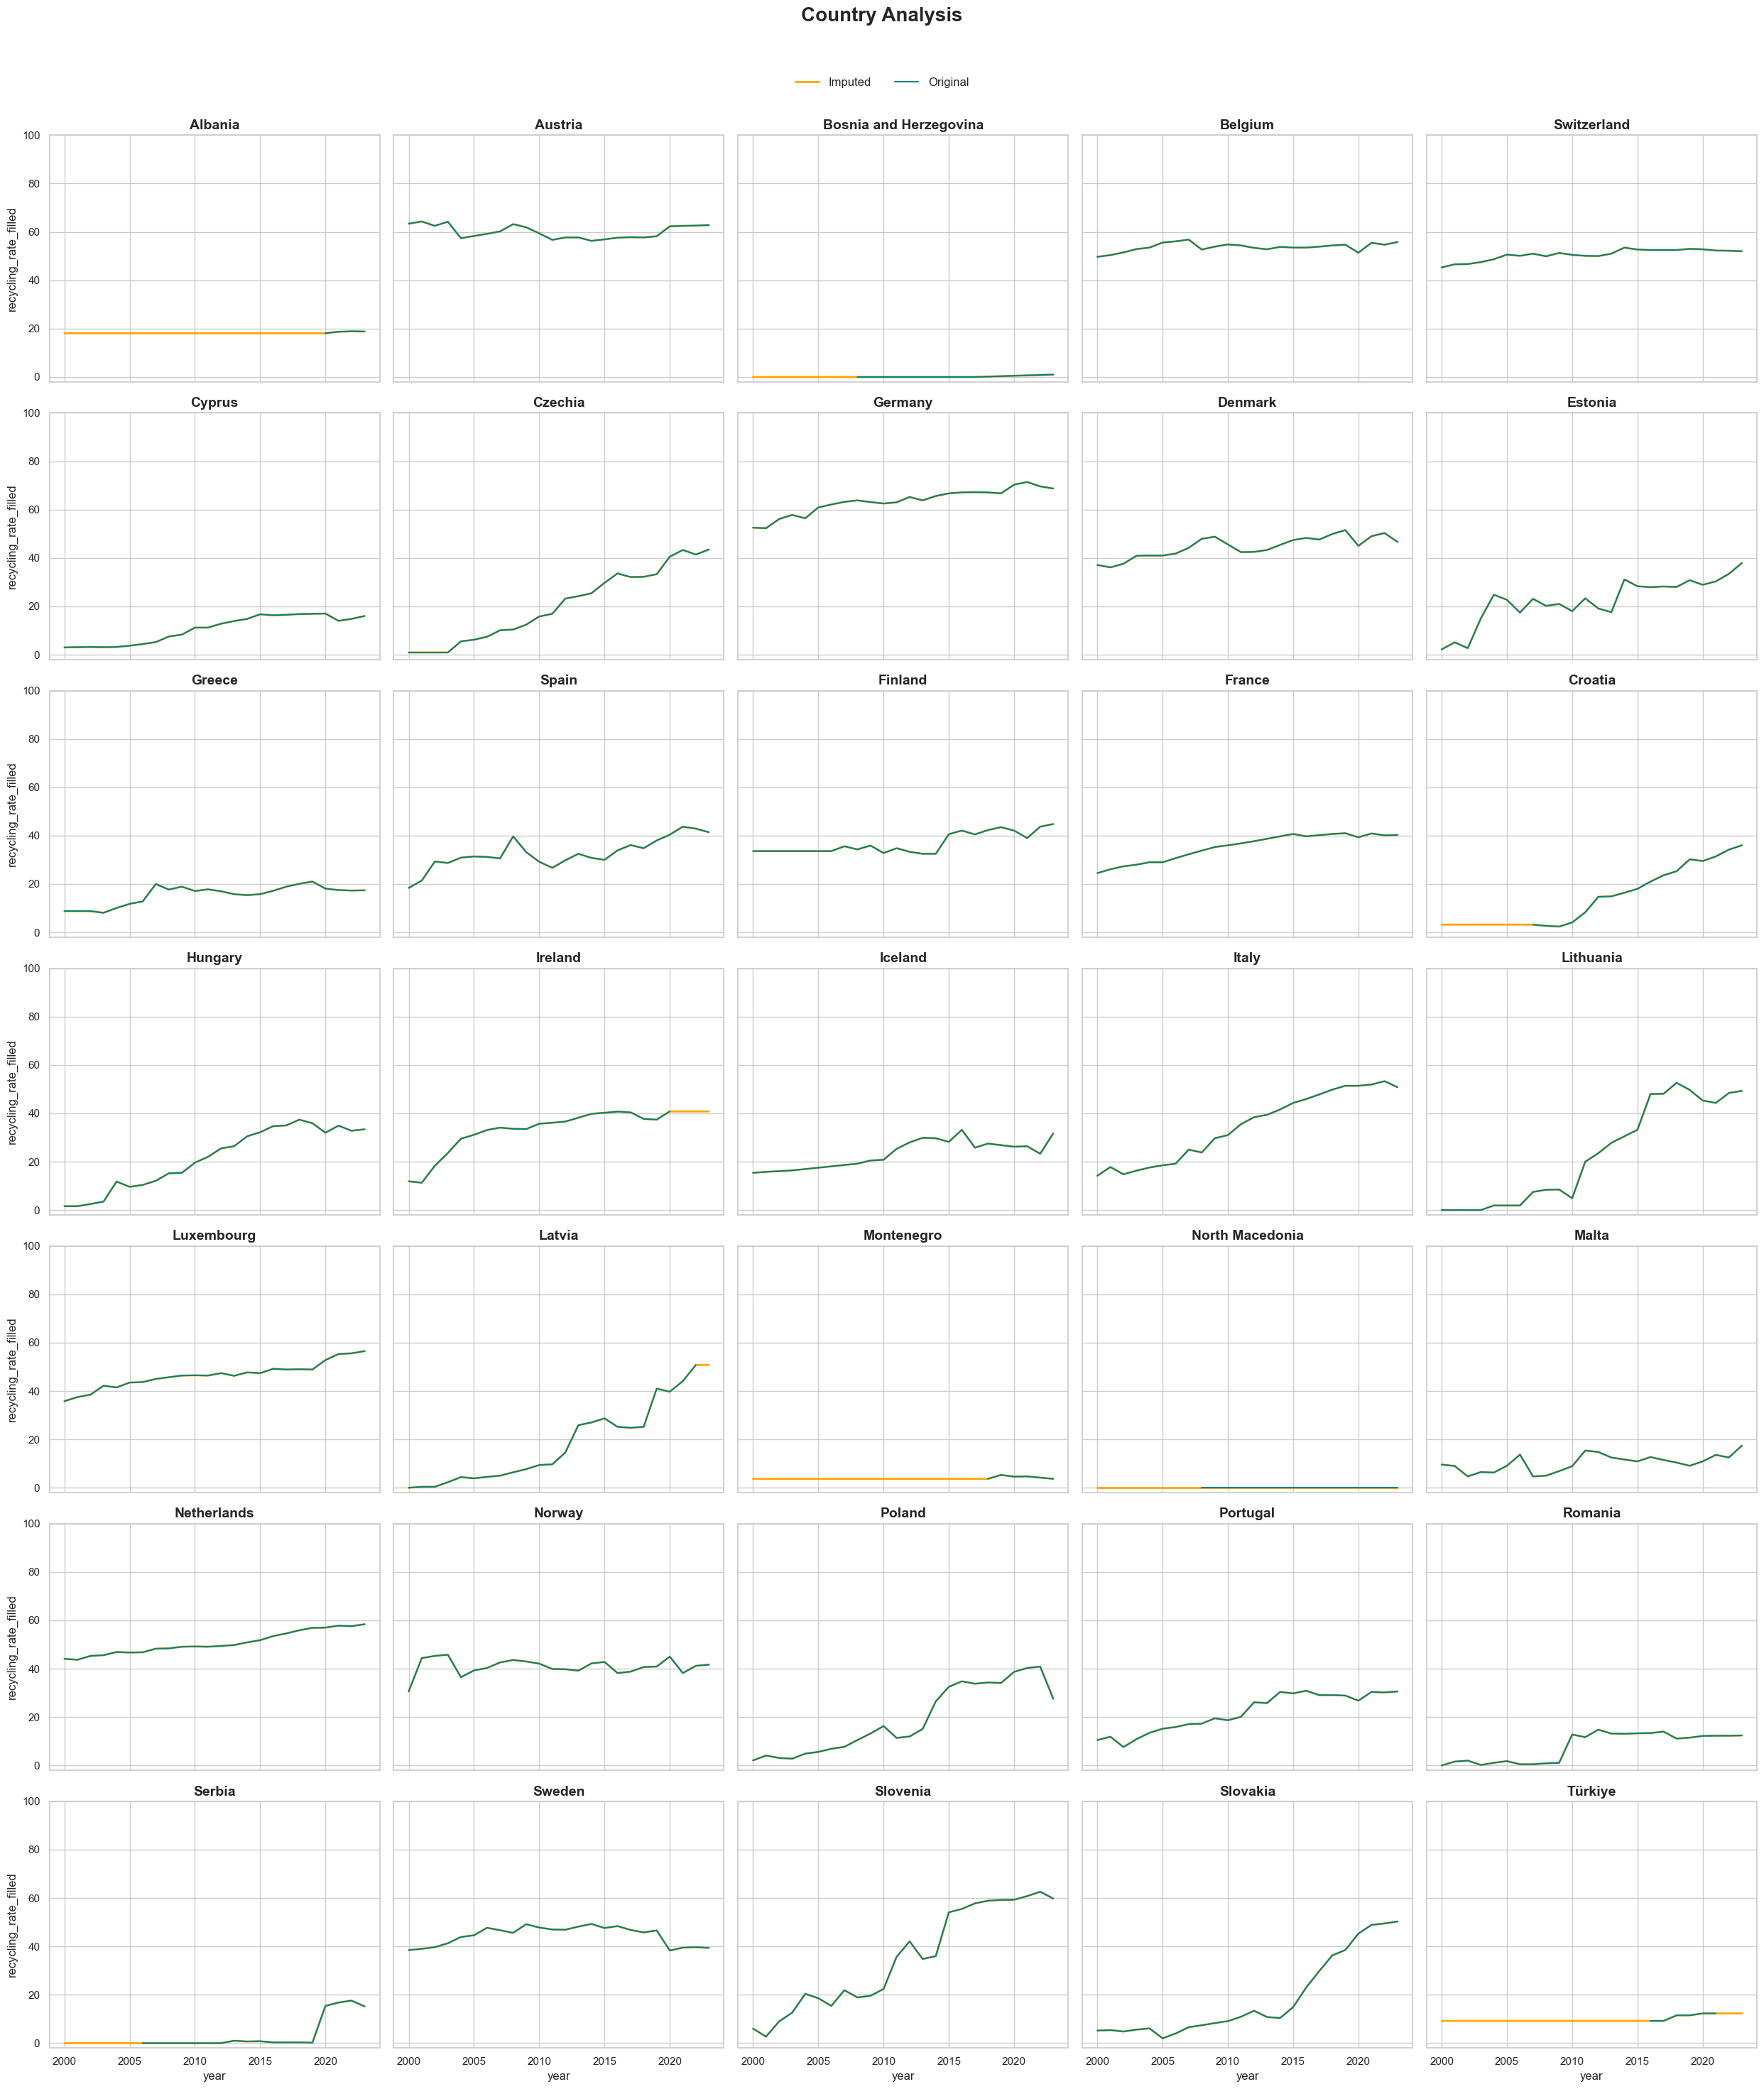

In [313]:
original_v_imputed = {
    'recycling_rate_filled': {'color': 'orange', 'lw': 2, 'alpha': 0.6, 'label': 'Imputed'},
    'recycling_rate': {'color': 'teal', 'lw': 1.5, 'marker': 'o', 'ms': 4, 'label': 'Original'}
}

plot_country_dashboard(res_d1_d3, original_v_imputed, cols=5);

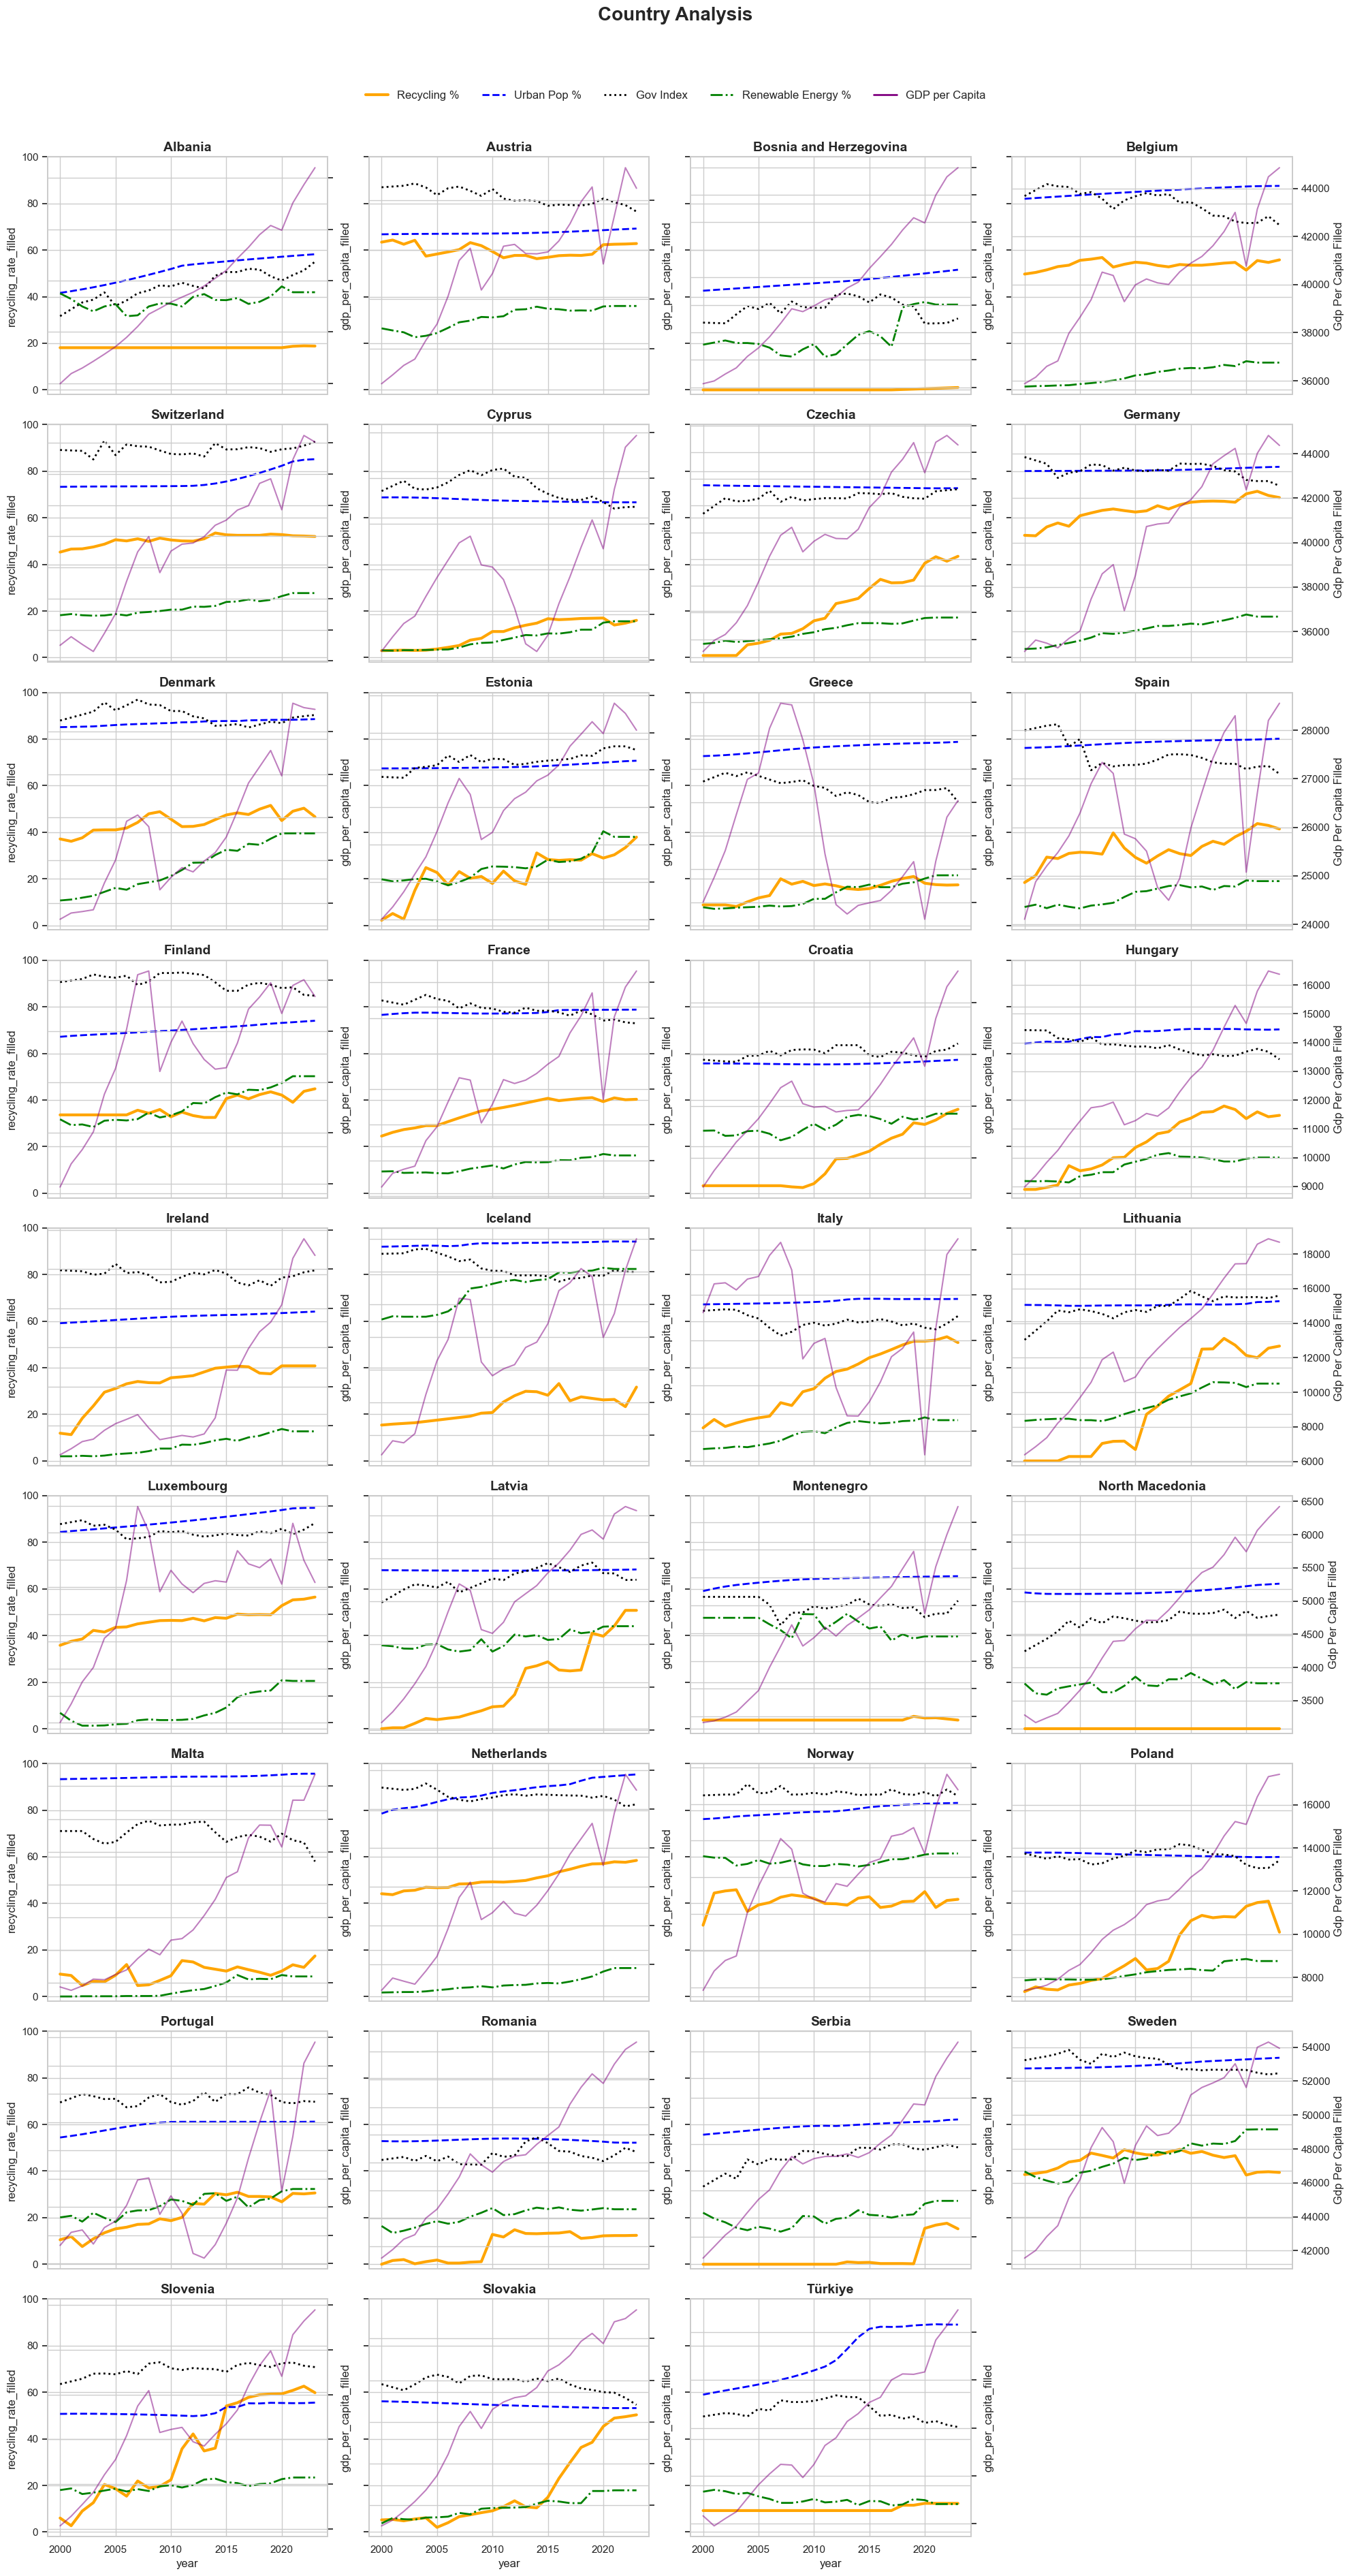

In [314]:
# Rescaling government effectiveness to 0-100 for better visualization since it is between -2.5 and 2.5
plot_df = res_d1_d3.copy()
plot_df['gov_effectiveness_index'] = ((plot_df['government_effectiveness_estimate_filled'] + 2.5) / 5 * 100)

# Primary metrics
metrics_config = {
    'recycling_rate_filled': {'color': 'orange', 'lw': 3, 'label': 'Recycling %'},
    'urban_population_pct_filled': {'color': 'blue', 'ls': '--', 'label': 'Urban Pop %'},
    'gov_effectiveness_index': {'color': 'black', 'ls': ':', 'label': 'Gov Index'},
    'renewable_energy_pct_filled': {'color': 'green', 'ls': '-.', 'label': 'Renewable Energy %'},
    'gdp_per_capita_filled': {'color': 'purple', 'ls': '-', 'label': 'GDP per Capita'}
}

plot_country_dashboard(plot_df, metrics_config, secondary_metric='gdp_per_capita_filled');

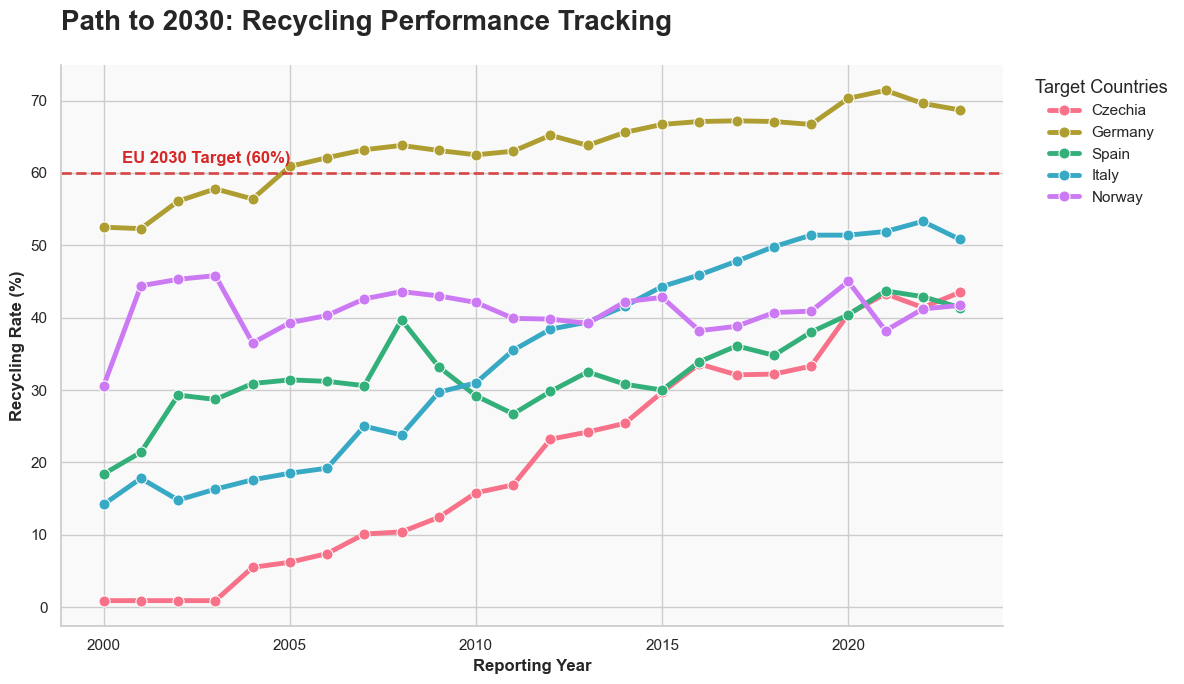

In [315]:
# Selecting 5 target countries for the management summary
targets = ['Germany', 'Norway', 'Italy', 'Czechia', 'Spain']
df_subset = res_d1_d3[res_d1_d3['country_name'].isin(targets)].copy()

sns.set_theme(style="whitegrid", rc={"axes.facecolor": "#f9f9f9"})
plt.figure(figsize=(12, 7))

palette = sns.color_palette("husl", len(targets))

line_plot = sns.lineplot(
    data=df_subset, 
    x='year', 
    y='recycling_rate_filled', 
    hue='country_name', 
    linewidth=3.5,
    marker='o',
    markersize=8,
    markeredgecolor='white',
    palette=palette
)

# EU 2030 target line
plt.axhline(y=60, color='#d62728', linestyle='--', linewidth=2, alpha=0.8)

plt.text(2000.5, 61, 'EU 2030 Target (60%)', color='#d62728', 
         fontweight='bold', fontsize=12, va='bottom')

plt.title("Path to 2030: Recycling Performance Tracking", 
          fontsize=20, fontweight='bold', pad=25, loc='left')


plt.ylabel("Recycling Rate (%)", fontsize=12, fontweight='bold')
plt.xlabel("Reporting Year", fontsize=12, fontweight='bold')

plt.legend(title="Target Countries", title_fontsize='13', 
           fontsize='11', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

sns.despine()

plt.tight_layout()
plt.show()

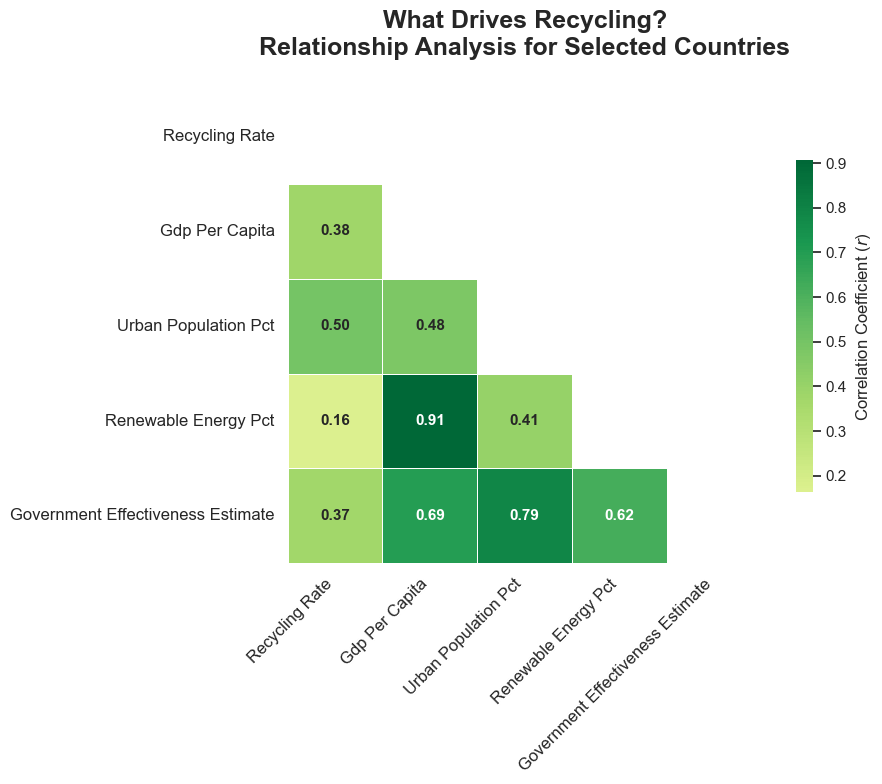

In [316]:
# Correlation analysis to identify drivers of recycling rates
core_indicators = [
    'recycling_rate_filled',
    'gdp_per_capita_filled',
    'urban_population_pct_filled',
    'renewable_energy_pct_filled',
    'government_effectiveness_estimate_filled']

sns.set_theme(style="white")
plt.figure(figsize=(10, 8))

df_corr = df_subset[core_indicators].corr()
df_corr.columns = [c.replace('_filled', '').replace('_', ' ').title() for c in df_corr.columns]
df_corr.index = [i.replace('_filled', '').replace('_', ' ').title() for i in df_corr.index]


mask = np.triu(np.ones_like(df_corr, dtype=bool))

sns.heatmap(
    df_corr, 
    mask=mask, 
    annot=True, 
    fmt=".2f", 
    cmap='RdYlGn', 
    center=0,
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .7, "label": "Correlation Coefficient ($r$)"},
    annot_kws={"size": 11, "weight": "bold"}
)

plt.title("What Drives Recycling?\nRelationship Analysis for Selected Countries", 
          fontsize=18, pad=25, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout()
plt.show()

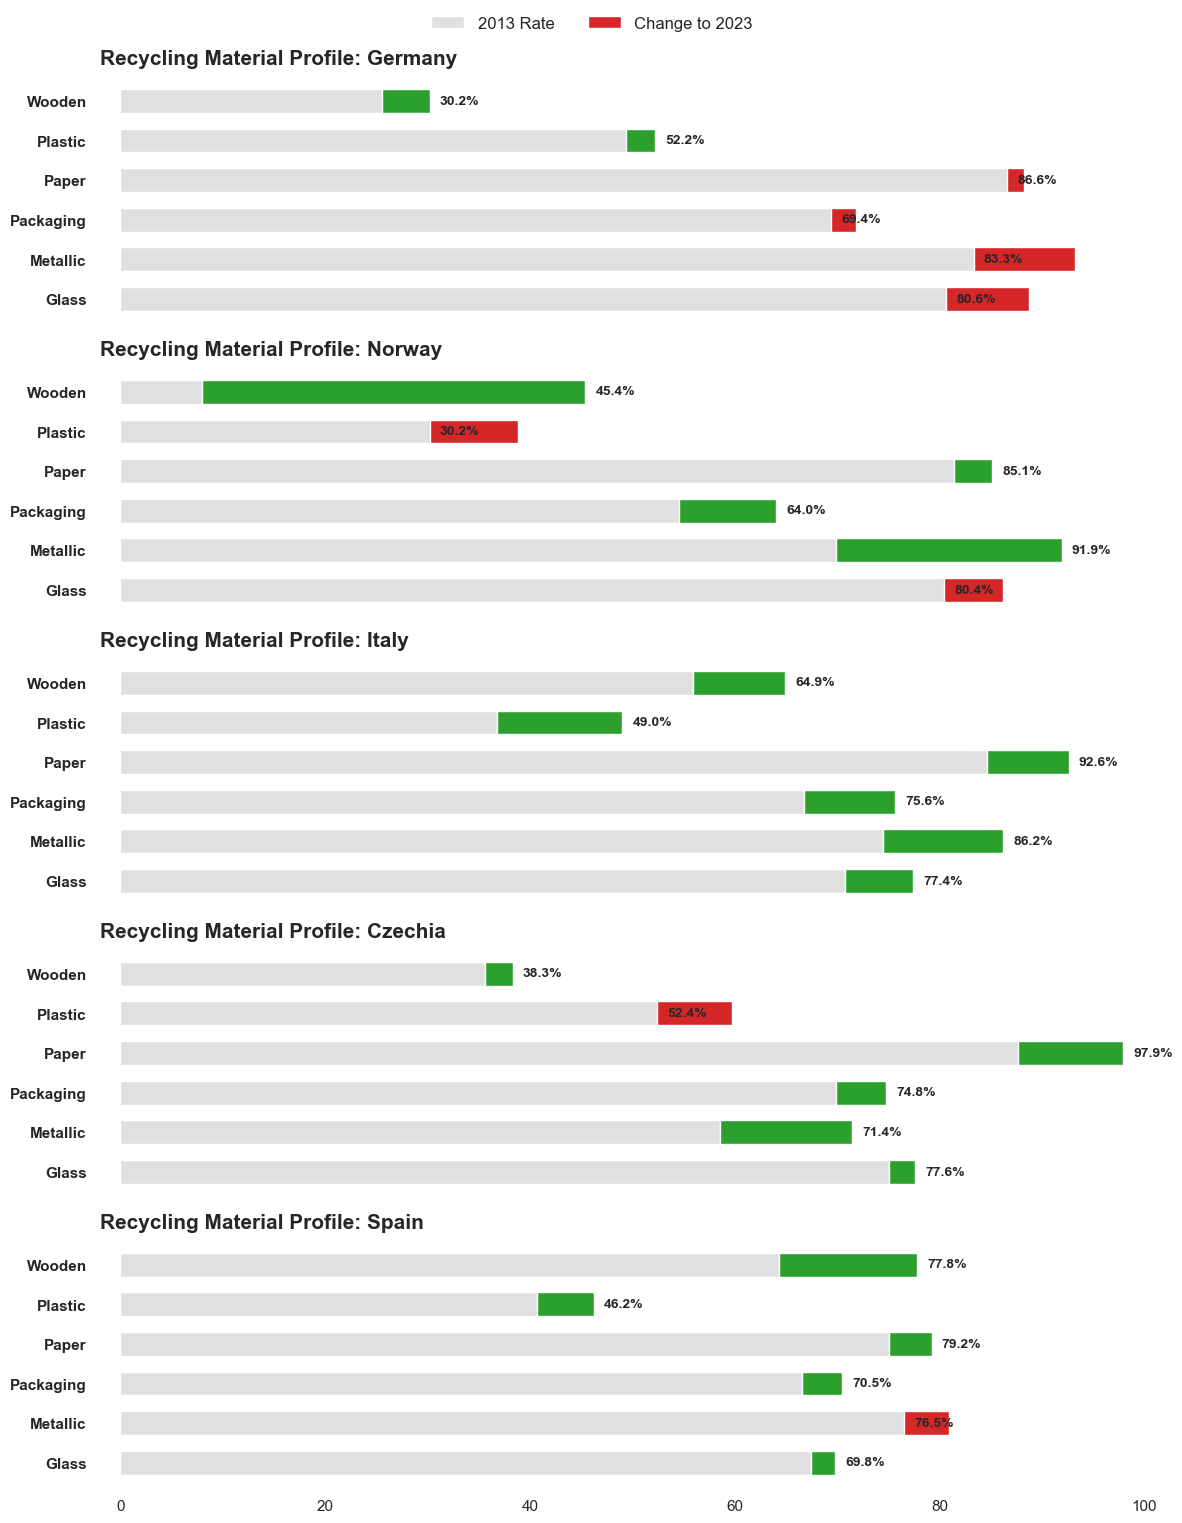

In [317]:
# Selecting the same 5 target countries for horizontal comparison
targets = ['Germany', 'Norway', 'Italy', 'Czechia', 'Spain']
latest_year = res_d2_d3['year'].max()
material_cols = [c for c in res_d2_d3.columns if 'recycling_rate_filled_' in c]
material_labels = [m.replace('recycling_rate_filled_', '').title() for m in material_cols]

# Plotting horizontal bar charts for each country
fig, axes = plt.subplots(len(targets), 1, figsize=(12, len(targets) * 3), sharex=True)
sns.set_theme(style="whitegrid")

for i, country in enumerate(targets):
    ax = axes[i]
    
    # extract data points
    d2013 = res_d2_d3[(res_d2_d3['country_name'] == country) & (res_d2_d3['year'] == 2013)][material_cols].values.flatten()
    dLatest = res_d2_d3[(res_d2_d3['country_name'] == country) & (res_d2_d3['year'] == latest_year)][material_cols].values.flatten()
    
    y_pos = np.arange(len(material_labels))

    # Show the 2013 baseline
    ax.barh(y_pos, d2013, color='#e0e0e0', label='2013 Rate', height=0.6)
    
    # Show the improvement (green) or decline (red)
    diff = dLatest - d2013
    colors = ['#2ca02c' if x >= 0 else '#d62728' for x in diff]
    ax.barh(y_pos, diff, left=d2013, color=colors, label=f'Change to {latest_year}', height=0.6)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(material_labels, fontweight='bold', fontsize=11)
    ax.set_title(f"Recycling Material Profile: {country}", fontsize=15, fontweight='bold', loc='left', pad=10)
    ax.set_xlim(-2, 100) # Added padding at 0 to see small bars
    
    # data labels
    for j, val in enumerate(dLatest):
        ax.text(val + 1, j, f"{val:.1f}%", va='center', fontsize=10, fontweight='bold')

    sns.despine(left=True, bottom=True)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=2, frameon=False, fontsize=12)

plt.tight_layout()
plt.show()

## Dataset preperation for recycling rate prediction

In [318]:
countries_to_drop = [
    "Bosnia and Herzegovina",
    "Montenegro",
    "North Macedonia",
    "Türkiye",
    "Serbia",
    "Albania"
]

res_d1_d3 = res_d1_d3[
    ~res_d1_d3["country_name"].isin(countries_to_drop)
].copy()

display(res_d1_d3)
sorted(res_d1_d3["country_name"].unique())


,country_name,year,recycling_rate,flag,recycling_rate_filled,gdp_per_capita,urban_population_pct,internet_users_pct,renewable_energy_pct,tourism_arrivals,...,gdp_per_capita_filled,urban_population_pct_filled,internet_users_pct_filled,renewable_energy_pct_filled,tourism_arrivals_filled,population_total_filled,manufacturing_value_added_pct_gdp_filled,government_effectiveness_estimate_filled,highschool_completed_pct_filled,household_exp_percapita_filled
24,Austria,2000,63.4,<NA>,63.4,38571.085878,66.769024,33.7301,26.4,17982000.0,...,38571.085878,66.769024,33.7301,26.4,17982000.0,8011566.0,18.726691,1.847265,69.880554,21252.013579
25,Austria,2001,64.3,e,64.3,38929.753801,66.840816,39.1855,25.5,18180000.0,...,38929.753801,66.840816,39.1855,25.5,18180000.0,8042293.0,18.866506,1.863747,70.977476,21441.999891
26,Austria,2002,62.5,e,62.5,39313.722511,66.888746,36.5600,24.7,18611000.0,...,39313.722511,66.888746,36.5600,24.7,18611000.0,8081957.0,18.288924,1.880228,72.545595,21482.279938
27,Austria,2003,64.2,e,64.2,39569.288557,66.926357,42.7000,22.6,19078000.0,...,39569.288557,66.926357,42.7000,22.6,19078000.0,8121423.0,17.961343,1.930461,72.667772,21750.471777
28,Austria,2004,57.4,<NA>,57.4,40333.330718,66.955861,54.2800,23.2,19374000.0,...,40333.330718,66.955861,54.2800,23.2,19374000.0,8171966.0,17.802078,1.843771,73.362363,22117.628677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,Slovakia,2019,38.5,<NA>,38.5,18250.980248,53.366656,82.8537,17.6,NaN,...,18250.980248,53.366656,82.8537,17.6,15299000.0,5454147.0,18.702022,0.549659,87.699997,10191.260945
812,Slovakia,2020,45.3,<NA>,45.3,17763.856385,53.248200,89.9209,17.6,NaN,...,17763.856385,53.248200,89.9209,17.6,15299000.0,5458827.0,17.540637,0.502146,89.138705,10068.038830
813,Slovakia,2021,48.9,<NA>,48.9,18808.454050,53.190148,88.9256,17.9,NaN,...,18808.454050,53.190148,88.9256,17.9,15299000.0,5447247.0,16.627351,0.490656,89.813492,10346.860861
814,Slovakia,2022,49.5,<NA>,49.5,18964.829840,53.190283,89.0677,NaN,NaN,...,18964.829840,53.190283,89.0677,17.9,15299000.0,5431752.0,17.350643,0.378135,90.202710,11011.238385


['Austria',
 'Belgium',
 'Croatia',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hungary',
 'Iceland',
 'Ireland',
 'Italy',
 'Latvia',
 'Lithuania',
 'Luxembourg',
 'Malta',
 'Netherlands',
 'Norway',
 'Poland',
 'Portugal',
 'Romania',
 'Slovakia',
 'Slovenia',
 'Spain',
 'Sweden',
 'Switzerland']

In [319]:
def build_horizon_delta_dataset(
    df,
    horizon=7,
    start_year=2000,
    end_year=None,
    target_col="recycling_rate_filled",
    feature_cols=None
):
    """
    Builds a dataset where the target is the change in target_col over `horizon` years.
    """

    if end_year is None:
        end_year = df["year"].max() - horizon

    # anchor data (t)
    df_t = df[
        (df["year"] >= start_year) &
        (df["year"] <= end_year)
    ][["country_name", "year"] + feature_cols].copy()

    # future data (t + horizon)
    df_t_future = df[
        (df["year"] >= start_year + horizon) &
        (df["year"] <= end_year + horizon)
    ][["country_name", "year", target_col]].copy()

    df_t_future["year"] -= horizon

    # merge
    merged = df_t.merge(
        df_t_future,
        on=["country_name", "year"],
        how="inner",
        suffixes=("", "_future")
    )

    # delta target
    merged[f"delta_{target_col}_{horizon}yr"] = (
        merged[f"{target_col}_future"] - merged[target_col]
    )

    return merged


In [320]:
feature_cols = [
    "recycling_rate_filled",
    "gdp_per_capita_filled",
    "urban_population_pct_filled",
    "internet_users_pct_filled",
    "renewable_energy_pct_filled",
    "tourism_arrivals_filled",
    "population_total_filled",
    "manufacturing_value_added_pct_gdp_filled",
    "government_effectiveness_estimate_filled",
    "highschool_completed_pct_filled",
    "household_exp_percapita_filled"
]

# build dataset with horizon recycling rates (in 7 years)
df_7yr = build_horizon_delta_dataset(
    feature_cols = feature_cols,
    df=res_d1_d3,
    horizon=7
)

display(df_7yr)

,country_name,year,recycling_rate_filled,gdp_per_capita_filled,urban_population_pct_filled,internet_users_pct_filled,renewable_energy_pct_filled,tourism_arrivals_filled,population_total_filled,manufacturing_value_added_pct_gdp_filled,government_effectiveness_estimate_filled,highschool_completed_pct_filled,household_exp_percapita_filled,recycling_rate_filled_future,delta_recycling_rate_filled_7yr
0,Austria,2000,63.4,38571.085878,66.769024,33.7301,26.4,17982000.0,8011566.0,18.726691,1.847265,69.880554,21252.013579,60.2,-3.2
1,Austria,2001,64.3,38929.753801,66.840816,39.1855,25.5,18180000.0,8042293.0,18.866506,1.863747,70.977476,21441.999891,63.2,-1.1
2,Austria,2002,62.5,39313.722511,66.888746,36.5600,24.7,18611000.0,8081957.0,18.288924,1.880228,72.545595,21482.279938,61.9,-0.6
3,Austria,2003,64.2,39569.288557,66.926357,42.7000,22.6,19078000.0,8121423.0,17.961343,1.930461,72.667772,21750.471777,59.4,-4.8
4,Austria,2004,57.4,40333.330718,66.955861,54.2800,23.2,19374000.0,8171966.0,17.802078,1.843771,73.362363,22117.628677,56.7,-0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,Slovakia,2012,13.4,15159.657042,54.276453,76.7100,10.5,12583000.0,5407579.0,17.274594,0.781548,85.379997,8550.429789,38.5,25.1
489,Slovakia,2013,10.8,15249.882451,54.138402,77.8826,10.7,12583000.0,5413393.0,16.667962,0.725381,85.959999,8440.424965,45.3,34.5
490,Slovakia,2014,10.4,15647.649176,54.002913,79.9843,12.2,11556000.0,5418649.0,18.534175,0.793423,85.320000,8590.790573,48.9,38.5
491,Slovakia,2015,14.9,16442.076086,53.870063,77.6347,13.4,14936000.0,5423801.0,18.828764,0.736977,86.690002,8820.036506,49.5,34.6


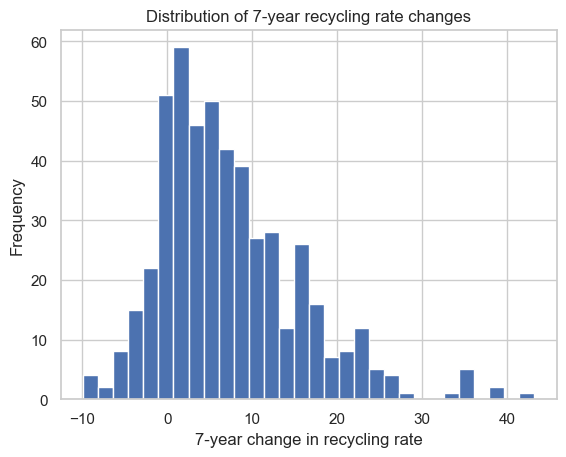

In [321]:
import matplotlib.pyplot as plt

plt.hist(df_7yr["delta_recycling_rate_filled_7yr"], bins=30)
plt.xlabel("7-year change in recycling rate")
plt.ylabel("Frequency")
plt.title("Distribution of 7-year recycling rate changes")
plt.show()

## Check for diminsihing returns 

We want to check that higher starting rate → smaller improvement

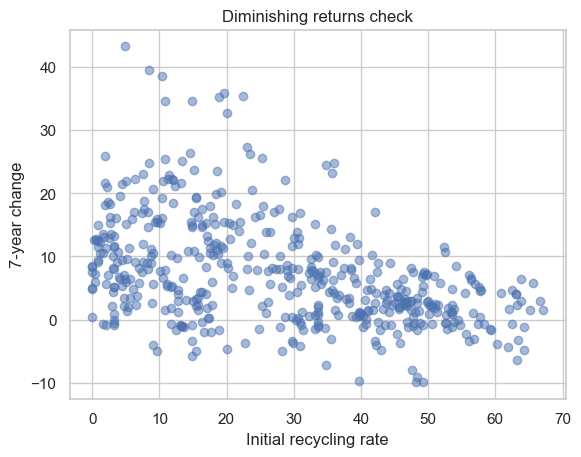

In [322]:
plt.scatter(
    df_7yr["recycling_rate_filled"],
    df_7yr["delta_recycling_rate_filled_7yr"],
    alpha=0.5
)
plt.xlabel("Initial recycling rate")
plt.ylabel("7-year change")
plt.title("Diminishing returns check")
plt.show()

## Split the data for delta = 7

In [323]:
# Create training and validation/test datasets
train_df = df_7yr[df_7yr["year"] <= 2012].copy()
val_df   = df_7yr[df_7yr["year"] > 2012].copy()

In [324]:
# Defining feature and target variables
target = "delta_recycling_rate_filled_7yr"

X_train = train_df[feature_cols]
y_train = train_df[target]

X_val = val_df[feature_cols]
y_val = val_df[target]

## Baseline Model: Linear regression (with regularization)

In [325]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

# Build a regression pipeline that scales features and fits a Ridge regression model
baseline_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

baseline_model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"alpha alpha: {float, ndarray of shape (n_targets,)}, default=1.0Constant that multiplies the L2 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Ridge` object is not advised.Instead, you should use the :class:`LinearRegression` object.If an array is passed, penalties are assumed to be specific to thetargets. Hence they must correspond in number.",1.0
,"fit_intercept fit_intercept: bool, default=TrueWhether to fit the intercept for this model. If setto false, no intercept will be used in calculations(i.e. ``X`` and ``y`` are expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=NoneMaximum number of iterations for conjugate gradient solver.For 'sparse_cg' and 'lsqr' solvers, the default value is determinedby scipy.sparse.linalg. For 'sag' solver, the default value is 1000.For 'lbfgs' solver, the default value is 15000.",None


In [326]:
from sklearn.metrics import mean_absolute_error, r2_score

# Generate predictions on validation set and evaluate model performance using MAE and R²
y_pred = baseline_model.predict(X_val)

print("MAE:", mean_absolute_error(y_val, y_pred))
print("R²:", r2_score(y_val, y_pred))

MAE: 6.084509327350794
R²: 0.29149213146269826


In [327]:
# Check coefficients of the regression model
coefs = pd.Series(
    baseline_model.named_steps["model"].coef_,
    index=X_train.columns
).sort_values()

coefs

recycling_rate_filled                      -6.031912
urban_population_pct_filled                -1.946564
renewable_energy_pct_filled                -1.074234
tourism_arrivals_filled                    -0.685326
household_exp_percapita_filled             -0.562771
manufacturing_value_added_pct_gdp_filled    0.415630
gdp_per_capita_filled                       0.779522
government_effectiveness_estimate_filled    1.087901
highschool_completed_pct_filled             1.429338
population_total_filled                     2.264625
internet_users_pct_filled                   2.426276
dtype: float64

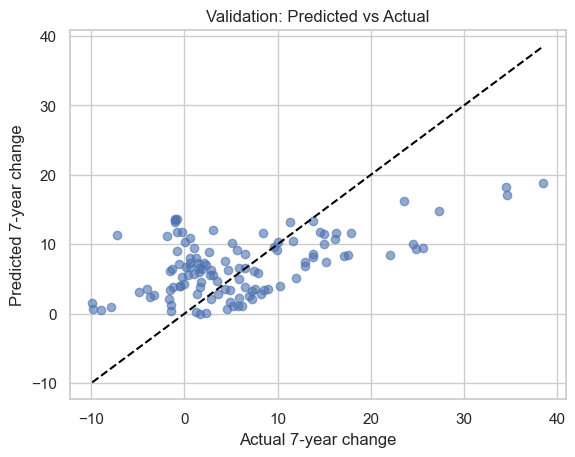

In [328]:
# Plot predicted over actual 7-year change
plt.scatter(y_val, y_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         "--", color="black")
plt.xlabel("Actual 7-year change")
plt.ylabel("Predicted 7-year change")
plt.title("Validation: Predicted vs Actual")
plt.show()

In [329]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor
)

# Define helper functions
def evaluate_model(model, X_train, y_train, X_val, y_val, name="model"):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)
    return mae, r2, model, preds

def cast_int_or_none(x):
    return None if pd.isna(x) else int(x)

## Non-linear Model: Random Forest

In [330]:
# Define basline RF model 
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)

rf_mae, rf_r2, _, _ = evaluate_model(rf_model, X_train, y_train, X_val, y_val)

print("RF Baseline MAE:", rf_mae)
print("RF Baseline R²:", rf_r2)

RF Baseline MAE: 4.564724827586202
RF Baseline R²: 0.5495659136792732


In [331]:
# Manual tuning to optimize hyperparameters (n_estimators, max_depth, min_samples_leaf, min_samples_split, max_features)
results = []

for n_estimators in [200, 400, 800]:
    for max_depth in [None, 8, 12]:
        for min_leaf in [1, 2, 4]:
            for min_split in [2, 5, 10]:
                for max_feat in ["sqrt", "log2", None]:

                    rf = RandomForestRegressor(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_leaf=min_leaf,
                        min_samples_split=min_split,
                        max_features=max_feat,
                        random_state=42,
                    )

                    mae, r2, _, _ = evaluate_model(rf, X_train, y_train, X_val, y_val)

                    results.append({
                        "n_estimators": n_estimators,
                        "max_depth": max_depth,
                        "min_samples_leaf": min_leaf,
                        "min_samples_split": min_split,
                        "max_features": max_feat,
                        "MAE": mae,
                        "R2": r2
                    })

rf_results = pd.DataFrame(results).sort_values("MAE")

rf_results

,n_estimators,max_depth,min_samples_leaf,min_samples_split,max_features,MAE,R2
2,200,NaN,1,2,None,4.486417,0.562108
5,200,NaN,1,5,None,4.504487,0.556760
68,200,12.0,2,5,None,4.516463,0.558894
59,200,12.0,1,5,None,4.524793,0.555286
164,800,NaN,1,2,None,4.527182,0.555806
...,...,...,...,...,...,...,...
133,400,8.0,4,10,log2,5.036813,0.465847
25,200,NaN,4,10,log2,5.041053,0.456503
24,200,NaN,4,10,sqrt,5.041053,0.456503
78,200,12.0,4,10,sqrt,5.041169,0.456434


Best RF MAE: 4.486416810344828
Best RF R²: 0.5621075165154144


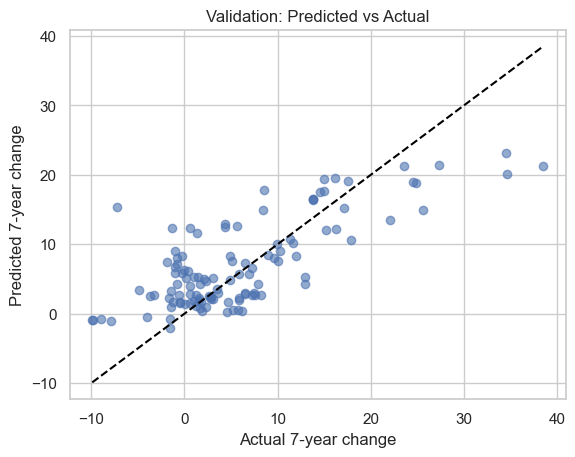

recycling_rate_filled                       0.185741
government_effectiveness_estimate_filled    0.139185
highschool_completed_pct_filled             0.124415
urban_population_pct_filled                 0.100450
population_total_filled                     0.086280
household_exp_percapita_filled              0.085250
internet_users_pct_filled                   0.072515
gdp_per_capita_filled                       0.056273
renewable_energy_pct_filled                 0.054608
manufacturing_value_added_pct_gdp_filled    0.051873
tourism_arrivals_filled                     0.043409
dtype: float64


In [332]:
# Investigate best performing RF model (MAE, R2 & Importances)
best_rf = RandomForestRegressor(
    n_estimators=rf_results.iloc[0]["n_estimators"],
    max_depth=cast_int_or_none(rf_results.iloc[0]["max_depth"]),
    min_samples_leaf=rf_results.iloc[0]["min_samples_leaf"],
    min_samples_split=rf_results.iloc[0]["min_samples_split"],
    max_features=rf_results.iloc[0]["max_features"],
    random_state=42,
)

best_rf_mae, best_rf_r2, best_rf, best_rf_preds = evaluate_model(best_rf, X_train, y_train, X_val, y_val)

print("Best RF MAE:", best_rf_mae)
print("Best RF R²:", best_rf_r2)

plt.scatter(y_val, best_rf_preds, alpha=0.6)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         "--", color="black")
plt.xlabel("Actual 7-year change")
plt.ylabel("Predicted 7-year change")
plt.title("Validation: Predicted vs Actual")
plt.show()

importances = pd.Series(best_rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(importances)

## Non-linear Model: Gradient Boosting

In [333]:
# Define baseline Gradient Boosting model
gbr = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

gbr_mae, gbr_r2, _, _ = evaluate_model(gbr, X_train, y_train, X_val, y_val)

print("GBR Baseline MAE:", gbr_mae)
print("GBR Baseline R²:", gbr_r2)

GBR Baseline MAE: 4.5574926007008
GBR Baseline R²: 0.5772583503293822


In [334]:
# Manual tuning to optimize hyperparameters (n_estimators, learning_rate, max_depth, min_samples_leaf, subsample)

gbr_results = []

for n_estimators in [200, 400, 800]:
    for learning_rate in [0.03, 0.05, 0.1]:
        for max_depth in [2, 3, 4]:
            for min_leaf in [1, 3, 5]:
                for subsample in [0.7, 0.9, 1.0]:

                    gbr = GradientBoostingRegressor(
                        n_estimators=n_estimators,
                        learning_rate=learning_rate,
                        max_depth=max_depth,
                        min_samples_leaf=min_leaf,
                        subsample=subsample,
                        random_state=42
                    )
                    
                    mae, r2, _, _ = evaluate_model(gbr, X_train, y_train, X_val, y_val)

                    gbr_results.append({
                        "n_estimators": n_estimators,
                        "learning_rate": learning_rate,
                        "max_depth": max_depth,
                        "min_samples_leaf": min_leaf,
                        "subsample": subsample,
                        "MAE": mae,
                        "R2": r2
                    })

gbr_results_df = (
    pd.DataFrame(gbr_results)
    .sort_values("MAE")
    .reset_index(drop=True)
)

gbr_results_df

,n_estimators,learning_rate,max_depth,min_samples_leaf,subsample,MAE,R2
0,800,0.05,4,5,0.7,4.019477,0.650365
1,400,0.05,4,5,0.7,4.025191,0.644559
2,800,0.05,4,1,0.7,4.102248,0.639382
3,800,0.05,3,5,0.7,4.121819,0.630292
4,800,0.05,4,3,0.7,4.124387,0.630771
...,...,...,...,...,...,...,...
238,200,0.03,3,1,1.0,5.297546,0.438766
239,200,0.03,2,3,0.7,5.327534,0.433195
240,200,0.03,2,3,1.0,5.385511,0.391113
241,200,0.03,2,5,1.0,5.448265,0.377768


Best GBR MAE: 4.019476863495803
Best GBR R²: 0.6503653331645987


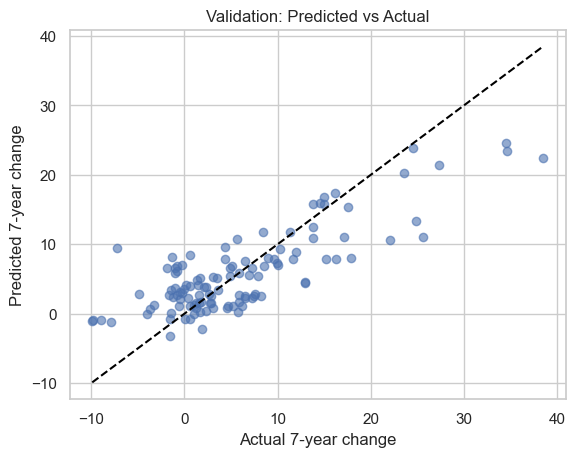

recycling_rate_filled                       0.177099
highschool_completed_pct_filled             0.135408
urban_population_pct_filled                 0.131772
government_effectiveness_estimate_filled    0.118977
population_total_filled                     0.099307
internet_users_pct_filled                   0.082359
gdp_per_capita_filled                       0.062246
renewable_energy_pct_filled                 0.053046
tourism_arrivals_filled                     0.051841
household_exp_percapita_filled              0.046989
manufacturing_value_added_pct_gdp_filled    0.040956
dtype: float64


In [335]:
# Investigate best performing GBR model (MAE, R2 & Importances)

best_gbr = GradientBoostingRegressor(
    n_estimators=cast_int_or_none(gbr_results_df.iloc[0]["n_estimators"]),
    learning_rate=gbr_results_df.iloc[0]["learning_rate"],
    max_depth=cast_int_or_none(gbr_results_df.iloc[0]["max_depth"]),
    min_samples_leaf=cast_int_or_none(gbr_results_df.iloc[0]["min_samples_leaf"]),
    subsample=gbr_results_df.iloc[0]["subsample"],
    random_state=42,
)

best_gbr_mae, best_gbr_r2, best_gbr, best_gbr_preds = evaluate_model(best_gbr, X_train, y_train, X_val, y_val)

print("Best GBR MAE:", best_gbr_mae)
print("Best GBR R²:", best_gbr_r2)

plt.scatter(y_val, best_gbr_preds, alpha=0.6)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         "--", color="black")
plt.xlabel("Actual 7-year change")
plt.ylabel("Predicted 7-year change")
plt.title("Validation: Predicted vs Actual")
plt.show()

importances = pd.Series(best_gbr.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(importances)

## Non-linear Model: Histogram-based Gradient Boosting

In [336]:
# Define basemodel HGB model

hgb = HistGradientBoostingRegressor(
    loss="absolute_error",
    max_iter=300,
    learning_rate=0.05,
    random_state=42
)

hgb_mae, hgb_r2, _, _ = evaluate_model(hgb, X_train, y_train, X_val, y_val)


print("HGB Baseline MAE:", hgb_mae)
print("HGB Baseline R²:", hgb_r2)

HGB Baseline MAE: 4.441305462511876
HGB Baseline R²: 0.5511212840672952


In [337]:
# Manual tuning to optimize hyperparameters (max_iter, learning_rate, max_depth, min_samples_leaf)

hgb_results = []

for max_iter in [300, 600, 1000]:
    for learning_rate in [0.03, 0.05, 0.1]:
        for max_depth in [3, 5, 7]:
            for min_samples_leaf in [10, 20, 40]:

                hgb = HistGradientBoostingRegressor(
                    max_iter=max_iter,
                    learning_rate=learning_rate,
                    max_depth=max_depth,
                    min_samples_leaf=min_samples_leaf,
                    random_state=42
                )

                mae, r2, _, _ = evaluate_model(hgb, X_train, y_train, X_val, y_val)

                hgb_results.append({
                    "max_iter": max_iter,
                    "learning_rate": learning_rate,
                    "max_depth": max_depth,
                    "min_samples_leaf": min_samples_leaf,
                    "MAE": mae,
                    "R2": r2
                })

hgb_results_df = (
    pd.DataFrame(hgb_results)
    .sort_values("MAE")
    .reset_index(drop=True)
)

hgb_results_df


,max_iter,learning_rate,max_depth,min_samples_leaf,MAE,R2
0,1000,0.05,5,10,4.139356,0.637599
1,600,0.05,5,10,4.139427,0.635008
2,300,0.05,5,10,4.192070,0.626001
3,600,0.10,3,10,4.205177,0.623711
4,1000,0.10,3,10,4.211498,0.625822
...,...,...,...,...,...,...
76,300,0.05,3,40,4.941363,0.459634
77,300,0.03,7,40,4.974969,0.453173
78,300,0.03,5,40,4.980985,0.457507
79,300,0.03,3,20,5.114890,0.459477


Best HGB MAE: 4.139355844233517
Best hgb R²: 0.6375988670117152


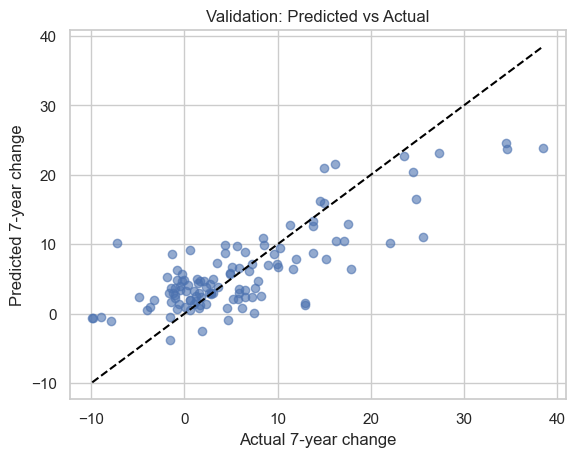

In [338]:
# Investigate best performing HGB model (MAE, R2)

best_hgb = HistGradientBoostingRegressor(
    max_iter=cast_int_or_none(hgb_results_df.iloc[0]["max_iter"]),
    learning_rate=hgb_results_df.iloc[0]["learning_rate"],
    max_depth=cast_int_or_none(hgb_results_df.iloc[0]["max_depth"]),
    min_samples_leaf=cast_int_or_none(hgb_results_df.iloc[0]["min_samples_leaf"]),
    random_state=42,
)

best_hgb_mae, best_hgb_r2, best_hgb, best_hgb_preds = evaluate_model(best_hgb, X_train, y_train, X_val, y_val)

print("Best HGB MAE:", best_hgb_mae)
print("Best hgb R²:", best_hgb_r2)

plt.scatter(y_val, best_hgb_preds, alpha=0.6)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         "--", color="black")
plt.xlabel("Actual 7-year change")
plt.ylabel("Predicted 7-year change")
plt.title("Validation: Predicted vs Actual")
plt.show()

## Non-linear Model: Extreme Gradient Boosting

In [339]:
!pip install xgboost

In [340]:
from xgboost import XGBRegressor

# Define Baseline XGB model
xgb = XGBRegressor(
    objective="reg:absoluteerror", 
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_mae, xgb_r2, _, _ = evaluate_model(xgb, X_train, y_train, X_val, y_val)

print("XGB Baseline MAE:", xgb_mae)
print("XGB Baseline R²:", xgb_r2)

XGB Baseline MAE: 4.403487245120301
XGB Baseline R²: 0.5785172490710646


In [341]:
from xgboost import XGBRegressor
import pandas as pd

# Manual tuning to optimize hyperparameters (n_estimators, learning_rate, max_depth, subsample, colsample_bytree)

xgb_results = []

for n_estimators in [300, 600, 1000]:
    for learning_rate in [0.03, 0.05, 0.1]:
        for max_depth in [3, 4, 5]:
            for subsample in [0.7, 0.9, 1.0]:
                for colsample in [0.7, 0.9, 1.0]:

                    xgb = XGBRegressor(
                        n_estimators=n_estimators,
                        learning_rate=learning_rate,
                        max_depth=max_depth,
                        subsample=subsample,
                        colsample_bytree=colsample,
                        random_state=42,
                    )

                    mae, r2, _, _ = evaluate_model(xgb, X_train, y_train, X_val, y_val)


                    xgb_results.append({
                        "n_estimators": n_estimators,
                        "learning_rate": learning_rate,
                        "max_depth": max_depth,
                        "subsample": subsample,
                        "colsample_bytree": colsample,
                        "MAE": mae,
                        "R2": r2
                    })

xgb_results_df = (
    pd.DataFrame(xgb_results)
    .sort_values("MAE")
    .reset_index(drop=True)
)

xgb_results_df

,n_estimators,learning_rate,max_depth,subsample,colsample_bytree,MAE,R2
0,600,0.10,3,0.7,0.7,4.049046,0.639097
1,1000,0.10,3,0.7,0.7,4.049727,0.639321
2,300,0.10,3,0.7,0.7,4.060913,0.633313
3,300,0.10,5,0.7,0.9,4.061717,0.638712
4,600,0.10,5,0.7,0.9,4.073809,0.638474
...,...,...,...,...,...,...,...
238,300,0.03,3,0.9,0.9,4.807069,0.519843
239,300,0.03,3,1.0,0.7,4.833992,0.528313
240,300,0.03,3,0.9,1.0,4.856145,0.513079
241,300,0.03,3,1.0,1.0,4.957930,0.492972


Best XGB MAE: 4.049046095402847
Best XGB R²: 0.6390967891026258


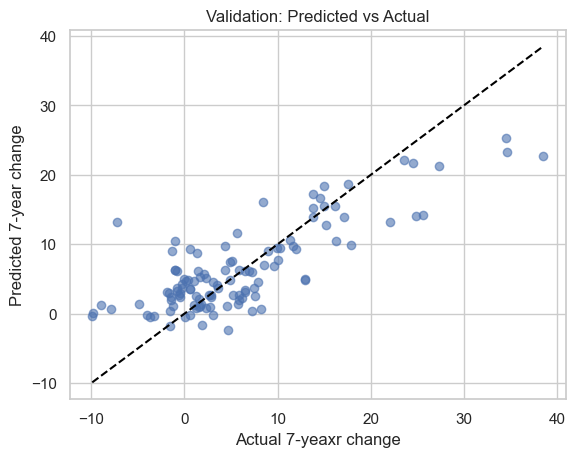

population_total_filled                     0.176573
urban_population_pct_filled                 0.125561
government_effectiveness_estimate_filled    0.109848
recycling_rate_filled                       0.101501
internet_users_pct_filled                   0.099326
highschool_completed_pct_filled             0.093744
household_exp_percapita_filled              0.086908
gdp_per_capita_filled                       0.074602
manufacturing_value_added_pct_gdp_filled    0.046725
tourism_arrivals_filled                     0.044171
renewable_energy_pct_filled                 0.041041
dtype: float32


In [342]:
# Investigate best performing XGB model (MAE, R2 & Importances)

best_xgb = XGBRegressor(
    n_estimators=cast_int_or_none(xgb_results_df.iloc[0]["n_estimators"]),
    learning_rate=xgb_results_df.iloc[0]["learning_rate"],
    max_depth=cast_int_or_none(xgb_results_df.iloc[0]["max_depth"]),
    subsample=xgb_results_df.iloc[0]["subsample"],
    colsample_bytree=xgb_results_df.iloc[0]["colsample_bytree"],
    random_state=42,
)

best_xgb_mae, best_xgb_r2, best_xgb, best_xgb_preds = evaluate_model(best_xgb, X_train, y_train, X_val, y_val)

print("Best XGB MAE:", best_xgb_mae)
print("Best XGB R²:", best_xgb_r2)

plt.scatter(y_val, best_xgb_preds, alpha=0.6)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         "--", color="black")
plt.xlabel("Actual 7-yeaxr change")
plt.ylabel("Predicted 7-year change")
plt.title("Validation: Predicted vs Actual")
plt.show()

importances = pd.Series(best_xgb.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(importances)

## Would we see better MAE with 5 years delta (instead of 7)? 

In [345]:
# Resplitting dataset for delta of 5 years

df_5yr = build_horizon_delta_dataset(
    feature_cols=feature_cols,
    df=res_d1_d3,
    horizon=5
)

train_df_5 = df_5yr[df_5yr["year"] <= 2014]
val_df_5   = df_5yr[df_5yr["year"] > 2014]

target_5 = "delta_recycling_rate_filled_5yr"

X_train_5 = train_df_5[feature_cols]
y_train_5 = train_df_5[target_5]

X_val_5 = val_df_5[feature_cols]
y_val_5 = val_df_5[target_5]

# Evaluatign previous optimized models for delta of 5 years
best_rf_5_mae , best_rf_5_r2, _, _ = evaluate_model(best_rf,  X_train_5, y_train_5, X_val_5, y_val_5, "RF (5yr)")
best_gbr_5_mae , best_gbr_5_r2, _, _ =evaluate_model(best_gbr, X_train_5, y_train_5, X_val_5, y_val_5, "GBR (5yr)")
best_hgb_5_mae , best_hgb_5_r2, _, _ =evaluate_model(best_hgb, X_train_5, y_train_5, X_val_5, y_val_5, "HGB (5yr)")
best_xgb_5_mae , best_xgb_5_r2, _, _ =evaluate_model(best_xgb, X_train_5, y_train_5, X_val_5, y_val_5, "XGB (5yr)")

results_5yr = {
    "RF (5yr)": (best_rf_5_mae, best_rf_5_r2),
    "GBR (5yr)": (best_gbr_5_mae, best_gbr_5_r2),
    "HGB (5yr)": (best_hgb_5_mae, best_hgb_5_r2),
    "XGB (5yr)": (best_xgb_5_mae, best_xgb_5_r2),
}

for model, (mae, r2) in results_5yr.items():
    print(f"{model:10s} | MAE: {mae:.3f} | R²: {r2:.3f}")

RF (5yr)   | MAE: 4.498 | R²: 0.168
GBR (5yr)  | MAE: 4.155 | R²: 0.347
HGB (5yr)  | MAE: 4.210 | R²: 0.234
XGB (5yr)  | MAE: 4.198 | R²: 0.322


Answer is no but we might need to retune the models for 5 years delta

## Predict recycling rates for dataset in 2030

In [346]:
predictions__df = res_d1_d3[res_d1_d3["year"] == res_d1_d3["year"].max()].copy()

# Features for prediction
X_latest = predictions__df[feature_cols]

# Predict 7-year delta from latest year
predicted_delta = best_xgb.predict(X_latest)

# Compute projected 2030 rate
predictions__df["predicted_delta_2030"] = predicted_delta
predictions__df["predicted_rate_2030"] = predictions__df["recycling_rate_filled"] + predicted_delta

eu_target = 60 
predictions__df["meets_target"] = predictions__df["predicted_rate_2030"] >= eu_target

projection_2030 = predictions__df[
    ["country_name", "recycling_rate_filled", "predicted_delta_2030", "predicted_rate_2030", "meets_target"]
].sort_values("predicted_rate_2030", ascending=False).reset_index(drop=True)

projection_2030

,country_name,recycling_rate_filled,predicted_delta_2030,predicted_rate_2030,meets_target
0,Germany,68.7,3.087647,71.787647,True
1,Slovenia,59.8,5.324357,65.124357,True
2,Slovakia,50.3,12.477269,62.777269,True
3,Austria,62.8,-1.052251,61.747749,True
4,Italy,50.8,6.951634,57.751634,False
5,Belgium,55.8,1.192301,56.992301,False
6,Luxembourg,56.5,-0.896707,55.603293,False
7,Netherlands,58.4,-2.995683,55.404317,False
8,Latvia,50.8,4.276478,55.076478,False
9,Switzerland,52.0,1.664185,53.664185,False


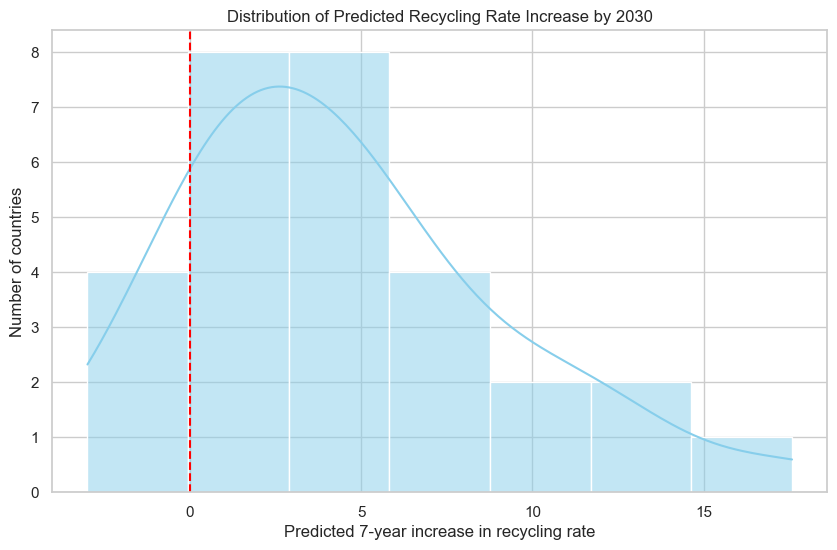

In [347]:
# show predicted deltas by 2030
plt.figure(figsize=(10,6))
sns.histplot(projection_2030["predicted_delta_2030"], bins=7, kde=True, color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Predicted 7-year increase in recycling rate")
plt.ylabel("Number of countries")
plt.title("Distribution of Predicted Recycling Rate Increase by 2030")
plt.show()

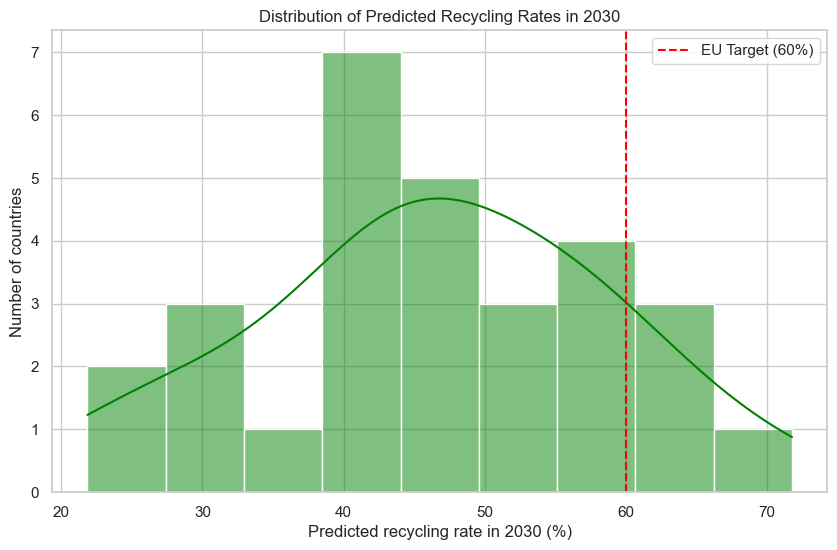

In [348]:
# Show predicted final recycling rates by 2030

plt.figure(figsize=(10,6))
sns.histplot(projection_2030["predicted_rate_2030"], bins=9, kde=True, color='green')
plt.axvline(eu_target, color='red', linestyle='--', label=f'EU Target ({eu_target}%)')
plt.xlabel("Predicted recycling rate in 2030 (%)")
plt.ylabel("Number of countries")
plt.title("Distribution of Predicted Recycling Rates in 2030")
plt.legend()
plt.show()

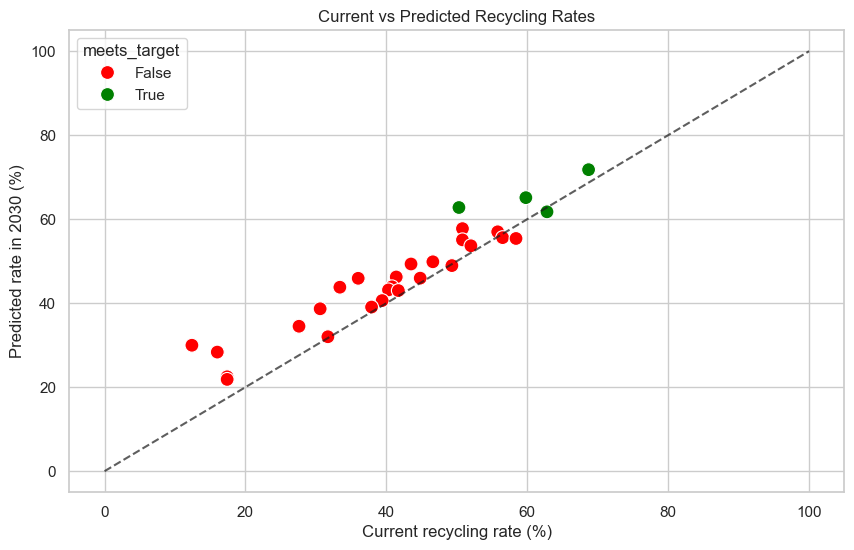

In [349]:
# Show Current vs preidcted recycling rates by 2030

plt.figure(figsize=(10,6))
sns.scatterplot(
    x="recycling_rate_filled",
    y="predicted_rate_2030",
    hue="meets_target",
    data=projection_2030,
    palette={True: 'green', False: 'red'},
    s=100
)
plt.plot([0, 100], [0, 100], 'k--', alpha=0.7)  # diagonal
plt.xlabel("Current recycling rate (%)")
plt.ylabel("Predicted rate in 2030 (%)")
plt.title("Current vs Predicted Recycling Rates")
plt.show()

## Countries with biggest predicted improvements

In [350]:
# Show countries with biggets predicted improvements 
top_increases = projection_2030.sort_values("predicted_delta_2030", ascending=False).head(10)
top_increases[["country_name", "recycling_rate_filled", "predicted_delta_2030", "predicted_rate_2030"]]

,country_name,recycling_rate_filled,predicted_delta_2030,predicted_rate_2030
25,Romania,12.4,17.581039,29.981039
2,Slovakia,50.3,12.477269,62.777269
26,Cyprus,16.0,12.354126,28.354126
17,Hungary,33.4,10.401758,43.801758
15,Croatia,36.0,9.922873,45.922873
22,Portugal,30.6,8.062968,38.662968
4,Italy,50.8,6.951634,57.751634
23,Poland,27.6,6.906212,34.506212
11,Czechia,43.5,5.826483,49.326483
1,Slovenia,59.8,5.324357,65.124357


## Countries by outcome analysis

/var/folders/bd/8whf37k56bd11spqccv7cc580000gn/T/ipykernel_980/552422199.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feat_imp_df, palette="viridis")


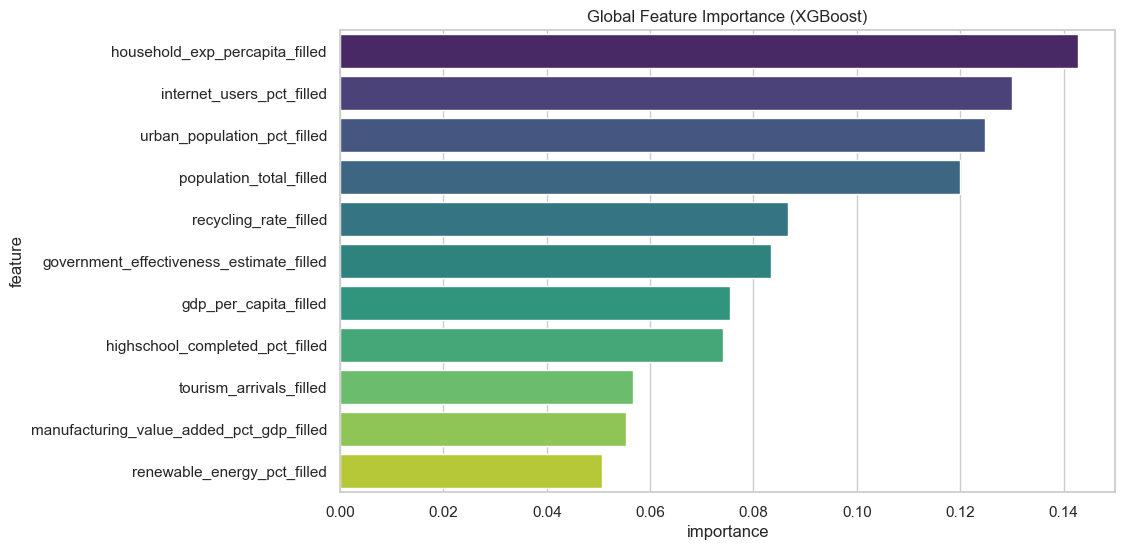

In [351]:
# Show most contriubting variables to recycling rates deltas
importances = best_xgb.feature_importances_
feat_imp_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=feat_imp_df, palette="viridis")
plt.title("Global Feature Importance (XGBoost)")
plt.show()

In [352]:
!pip install shap

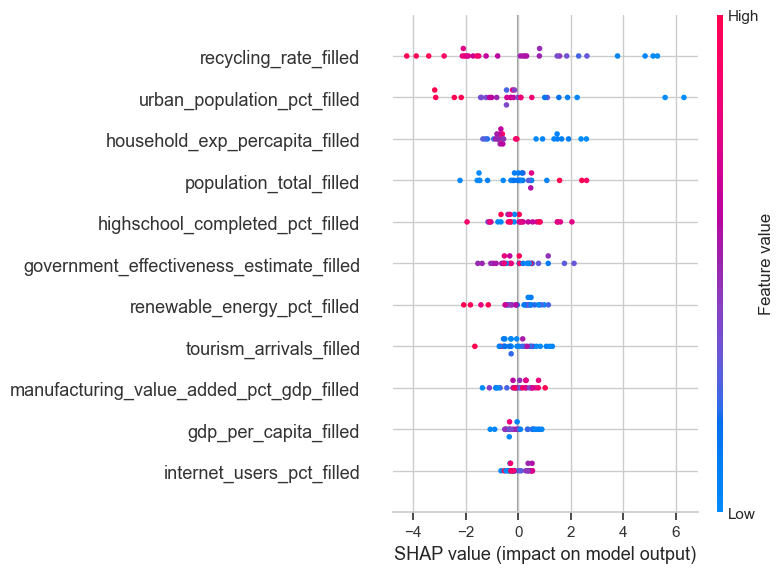

                                     feature  mean_abs_shap
0                      recycling_rate_filled       2.157130
2                urban_population_pct_filled       1.404172
10            household_exp_percapita_filled       0.997734
6                    population_total_filled       0.742959
9            highschool_completed_pct_filled       0.714935
8   government_effectiveness_estimate_filled       0.682398
4                renewable_energy_pct_filled       0.614887
5                    tourism_arrivals_filled       0.519599
7   manufacturing_value_added_pct_gdp_filled       0.468987
1                      gdp_per_capita_filled       0.430481
3                  internet_users_pct_filled       0.344311


In [353]:
import shap

explainer = shap.Explainer(best_xgb, X_latest)
shap_values = explainer(X_latest)

# Global summary
shap.summary_plot(shap_values, X_latest, feature_names=feature_cols)

# Mean absolute SHAP value per feature
shap_df = pd.DataFrame({
    "feature": feature_cols,
    "mean_abs_shap": np.abs(shap_values.values).mean(axis=0)
}).sort_values("mean_abs_shap", ascending=False)

print(shap_df)



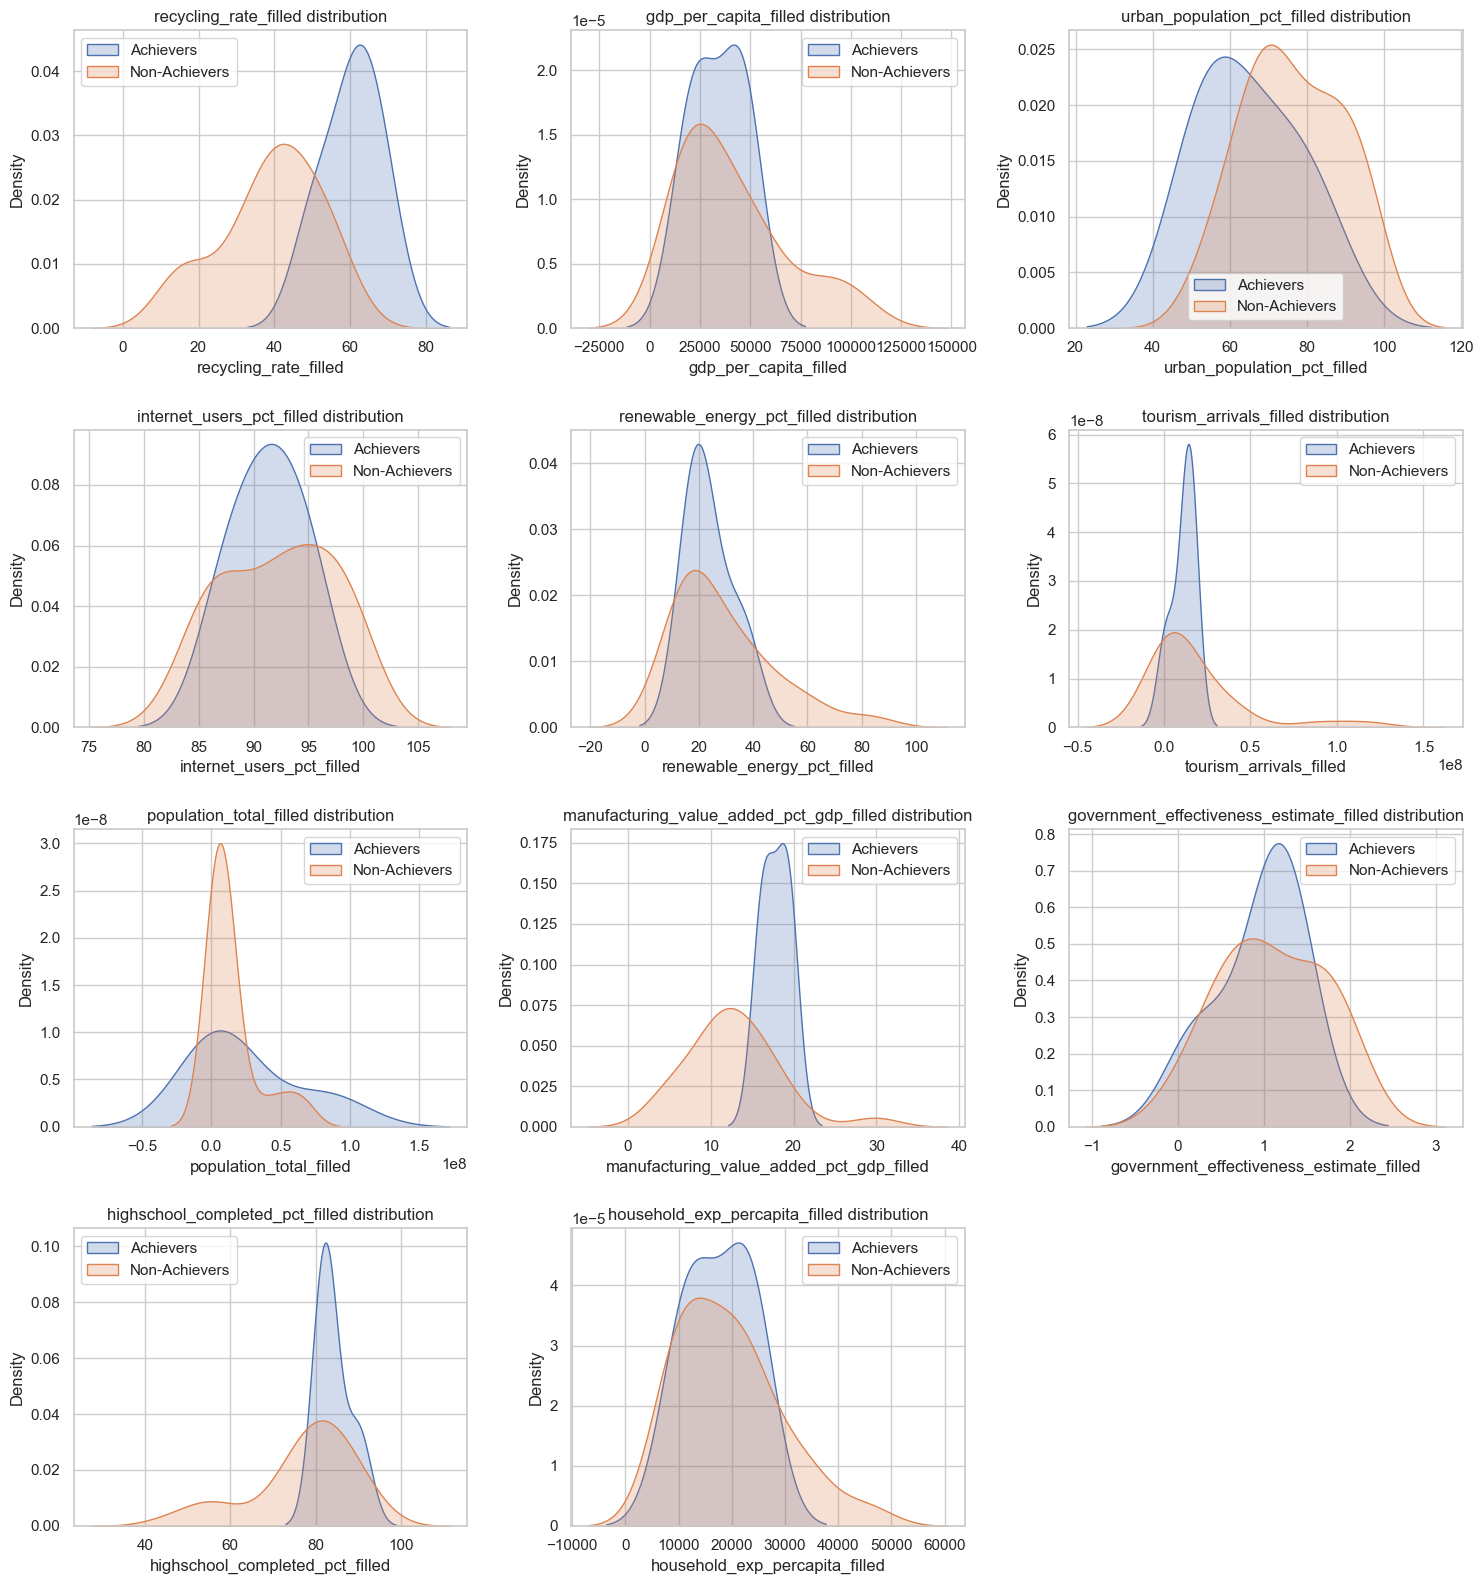

In [354]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Split dataset into achievers and non-achievers
achievers = predictions__df[predictions__df["meets_target"]].copy()
non_achievers = predictions__df[~predictions__df["meets_target"]].copy()

# Determine grid size
n_features = len(feature_cols)
n_cols = 3 
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()  # flatten for easy indexing

for i, feature in enumerate(feature_cols):
    sns.kdeplot(achievers[feature], label="Achievers", fill=True, ax=axes[i])
    sns.kdeplot(non_achievers[feature], label="Non-Achievers", fill=True, ax=axes[i])
    axes[i].set_title(f"{feature} distribution")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Density")
    axes[i].legend()

# Remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
